In [1]:
import emcee
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks,argrelmin
from scipy.stats import median_absolute_deviation
import eleanor
import urllib
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import TessTargetPixelFile
import eleanor
from astropy.io import ascii,fits
from astropy.table import Table,join
import astropy.units as u
import bokeh
import sys
from scipy.signal import savgol_filter
from requests.exceptions import HTTPError
import matplotlib.gridspec as gridspec
plt.rcParams['font.size']=12
import glob
from PyPDF2 import PdfFileMerger,PdfFileReader


def get_acf_period(lc):
    #t = data['time']
    #y = (data['flux'] - 1) * 1e3
    #yerr = (data['flux_err']) * 1e3

    t = lc.time
    y = (lc.flux-1) * 1e3
    #print(y)
    yerr = lc.flux_err * 1e3

    delta_t = np.median(np.diff(t))
    new_t = np.arange(t.min(), t.max(), delta_t)
    y_interp = np.interp(new_t, t, y)
    emp_acorr = emcee.autocorr.function_1d(y_interp) #* np.var(y_interp)

    #emp_acorr = emcee.autocorr.function_1d(y) * np.var(y)

    new_f = np.zeros(len(new_t))

    for i in range(len(lc.time)):
        t_diffs = np.abs(new_t - t[i])
        minindx = np.argmin(t_diffs)
        new_f[minindx] = y[i]

    #emp_acorr = emcee.autocorr.function_1d(y_interp)
    emp_acorr = emcee.autocorr.function_1d(new_f)

    #tau = np.arange(len(emp_acorr)) * delta_t

    emp_acorr_smooth = gaussian_filter1d(emp_acorr,350*delta_t)
    #print(emp_acorr_smooth)
    peakinds = find_peaks(emp_acorr_smooth)[0]
    peakvals = emp_acorr_smooth[peakinds]
    #print(peakinds)
    valinds = argrelmin(emp_acorr_smooth)[0]
    #print(valinds)

    tau = np.arange(len(emp_acorr_smooth)) * delta_t

    #emp_acorr_smooth[peakinds[0]] - emp_acorr_smooth[peakinds[1]] > 0
    peakheights = np.zeros(len(peakinds)-1)
    for i in range(len(peakinds)-1):
        peakheights[i] = np.mean((emp_acorr_smooth[peakinds[i]]-emp_acorr_smooth[valinds[i]], emp_acorr_smooth[peakinds[i]]-emp_acorr_smooth[valinds[i+1]]))

    #print(peakheights)
    #if len(peakheights) == 0:

    maxindx = np.argmax(peakheights)
    if maxindx == 1:
        maxindx = 1
        #print('!')

    elif maxindx != 1:
        maxindx = 0

    period=tau[peakinds[maxindx]]
    #print(period)
    maxheight=peakheights[maxindx]
    maxpeakval=peakvals[maxindx]


    integerinds = np.array([2,3,4,5],dtype=int)
    integermults = [period * n for n in range(2,6)]

    tau_prev = period
    periodmults = np.array([])
    linfit_peakinds = np.array([],dtype=int)
    peakdiffs = np.zeros(len(peakinds)-1)
    n = 1
    #for i in range(len(integermults)):
    #    for j in range(len(peakinds)):
    #        if (np.abs(integermults[i] - tau[peakinds[j]])/period <= 0.1) & ((tau[peakinds[j]]-tau_prev) > 0.5*period):
    #            #print(i,j)
    #            periodmults = np.concatenate((periodmults,[tau[peakinds[j]]]))
    #            tau_prev = tau[peakinds[j]]
    #            linfit_peakinds = np.concatenate((linfit_peakinds,[np.int(j)]))
    #            n += 1

    for i in range(len(integermults)):
        for j in range(len(peakinds)-1):
            peakdiffs[j] = np.abs(integermults[i] - tau[peakinds[j]])/period
        if np.min(peakdiffs) <= 0.2: # change to 0.2?
            jj = np.argmin(peakdiffs)
            if peakheights[jj]>= 0.1:
                periodmults = np.concatenate((periodmults,[tau[peakinds[jj]]]))
            #linfit_peakinds = np.concatenate((linfit_peakinds,[np.int(jj)]))
                linfit_peakinds = np.concatenate((linfit_peakinds,[integerinds[i]]))
                n += 1
            #if (np.abs(integermults[i] - tau[peakinds[j]])/period <= 0.1) & ((tau[peakinds[j]]-tau_prev) > 0.5*period):
                #print(i,j)
                #periodmults = np.concatenate((periodmults,[tau[peakinds[j]]]))
                #tau_prev = tau[peakinds[j]]
                #linfit_peakinds = np.concatenate((linfit_peakinds,[np.int(j)]))



    tauslice = tau[valinds[maxindx]:valinds[maxindx+1]]
    acfslice = emp_acorr_smooth[valinds[maxindx]:valinds[maxindx+1]]
    #plt.plot(tauslice,acfslice)
    halfheight = maxheight/2
    halfheightval = maxpeakval - halfheight
    #if maxheight <0:
    #    halfmax = maxheight*2
    #if maxheight < 0:
    #    halfmax = maxheight*2
    #print(halfmax)
    #print(acfslice)
    #absdiffs = np.abs(maxheight/2 - acfslice)
    absdiffs = np.abs(halfheightval - acfslice)
    #print(absdiffs)
    #print(absdiffs)
    #print(maxheight)
    #print(acfslice)
    minval1 = np.argmin(absdiffs)
    absdiffs=np.delete(absdiffs,minval1)
    minval2 = np.argmin(absdiffs)
    #print(minval1,minval2)
    #print(tauslice)
    #print(tauslice[minval1])
    #
    sigma_from_fwhm = (np.abs(period - tauslice[minval1]) + np.abs(period - tauslice[minval2]))/2.35482004503
    if (minval1 == minval2) | (minval1 == minval2+1) | (minval1 == minval2-1):
            #print('!!!')
            sigma_from_fwhm = (np.abs(period - tauslice[minval1]) * 2)/2.35482004503
            #print(period)
            ##print(tauslice[minval1])
            #print(sigma_from_fwhm)

    #print(sigma_from_fwhm)

    linfit_peakinds = np.concatenate(([maxindx],linfit_peakinds))
    #linfit_peakinds += 1
    linfit_peakinds = np.concatenate(([0],linfit_peakinds))
    #if linfit_peakinds[1] == 2:
    #    linfit_peakinds = linfit_peakinds / 2
    #print(linfit_peakinds)
    if linfit_peakinds[1] == 0:
        linfit_peakinds[1] = 1

    #print(np.str(n))
    if (n == 1) | (np.sum(np.diff(np.diff(linfit_peakinds)))) != 0:
        #print('X')
        periodmults = np.array([0,period])
        period_unc = sigma_from_fwhm
        finalperiod = period

    elif n > 1:
        #print('!')
        periodmults = np.concatenate(([0,period],periodmults))
        period_diffs = np.diff(periodmults)
        #print(period_diffs)
        #finalperiod = np.median(period_diffs)
        finalperiod = np.polyfit(linfit_peakinds,periodmults,1)[0]
        #print(linfit_peakinds)
        #print(periodmults)


        #print(median_absolute_deviation(period_diffs))
        #print(np.std(period_diffs))
        #print(n)
        
        period_unc = 1.483* median_absolute_deviation(period_diffs) / np.sqrt(n-1)
        if period_unc == 0:
            period_unc = np.std(period_diffs) / np.sqrt(n-1)
        #period_unc = sigma_from_fwhm


    return finalperiod, period_unc, tau, emp_acorr_smooth, peakinds, valinds, maxheight, periodmults
#plt.rcParams['font.size']=16

In [2]:
def get_acf_period(lc,smth):
    #t = data['time']
    #y = (data['flux'] - 1) * 1e3
    #yerr = (data['flux_err']) * 1e3

    t = lc.time
    y = (lc.flux-1) * 1e3
    #print(y)
    yerr = lc.flux_err * 1e3

    delta_t = np.median(np.diff(t))
    new_t = np.arange(t.min(), t.max(), delta_t)
    y_interp = np.interp(new_t, t, y)
    emp_acorr = emcee.autocorr.function_1d(y_interp) #* np.var(y_interp)

    #emp_acorr = emcee.autocorr.function_1d(y) * np.var(y)

    new_f = np.zeros(len(new_t))

    for i in range(len(lc.time)):
        t_diffs = np.abs(new_t - t[i])
        minindx = np.argmin(t_diffs)
        new_f[minindx] = y[i]

    #emp_acorr = emcee.autocorr.function_1d(y_interp)
    emp_acorr = emcee.autocorr.function_1d(new_f)

    #tau = np.arange(len(emp_acorr)) * delta_t

    emp_acorr_smooth = gaussian_filter1d(emp_acorr, smth*delta_t)
    #print(emp_acorr_smooth)
    peakinds = find_peaks(emp_acorr_smooth)[0]
    peakvals = emp_acorr_smooth[peakinds]
    #print(peakinds)
    valinds = argrelmin(emp_acorr_smooth)[0]
    #print(valinds)

    tau = np.arange(len(emp_acorr_smooth)) * delta_t

    #emp_acorr_smooth[peakinds[0]] - emp_acorr_smooth[peakinds[1]] > 0
    peakheights = np.zeros(len(peakinds)-1)
    for i in range(len(peakinds)-1):
        peakheights[i] = np.mean((emp_acorr_smooth[peakinds[i]]-emp_acorr_smooth[valinds[i]], emp_acorr_smooth[peakinds[i]]-emp_acorr_smooth[valinds[i+1]]))

    #print(peakheights)
    #if len(peakheights) == 0:

    maxindx = np.argmax(peakheights)
    if maxindx == 1:
        maxindx = 1
        #print('!')

    elif maxindx != 1:
        maxindx = 0

    period=tau[peakinds[maxindx]]
    #print(period)
    maxheight=peakheights[maxindx]
    maxpeakval=peakvals[maxindx]


    integerinds = np.array([2,3,4,5],dtype=int)
    integermults = [period * n for n in range(2,6)]

    tau_prev = period
    periodmults = np.array([])
    linfit_peakinds = np.array([],dtype=int)
    peakdiffs = np.zeros(len(peakinds)-1)
    n = 1
    #for i in range(len(integermults)):
    #    for j in range(len(peakinds)):
    #        if (np.abs(integermults[i] - tau[peakinds[j]])/period <= 0.1) & ((tau[peakinds[j]]-tau_prev) > 0.5*period):
    #            #print(i,j)
    #            periodmults = np.concatenate((periodmults,[tau[peakinds[j]]]))
    #            tau_prev = tau[peakinds[j]]
    #            linfit_peakinds = np.concatenate((linfit_peakinds,[np.int(j)]))
    #            n += 1

    for i in range(len(integermults)):
        for j in range(len(peakinds)-1):
            peakdiffs[j] = np.abs(integermults[i] - tau[peakinds[j]])/period
        if np.min(peakdiffs) <= 0.2: # change to 0.2?
            jj = np.argmin(peakdiffs)
            if (peakheights[jj]>= 0.5 * maxheight) | (peakheights[jj] >= 0.1): #0.1:
                periodmults = np.concatenate((periodmults,[tau[peakinds[jj]]]))
            #linfit_peakinds = np.concatenate((linfit_peakinds,[np.int(jj)]))
                linfit_peakinds = np.concatenate((linfit_peakinds,[integerinds[i]]))
                n += 1
            #if (np.abs(integermults[i] - tau[peakinds[j]])/period <= 0.1) & ((tau[peakinds[j]]-tau_prev) > 0.5*period):
                #print(i,j)
                #periodmults = np.concatenate((periodmults,[tau[peakinds[j]]]))
                #tau_prev = tau[peakinds[j]]
                #linfit_peakinds = np.concatenate((linfit_peakinds,[np.int(j)]))



    tauslice = tau[valinds[maxindx]:valinds[maxindx+1]]
    acfslice = emp_acorr_smooth[valinds[maxindx]:valinds[maxindx+1]]
    #plt.plot(tauslice,acfslice)
    halfheight = maxheight/2
    halfheightval = maxpeakval - halfheight
    #if maxheight <0:
    #    halfmax = maxheight*2
    #if maxheight < 0:
    #    halfmax = maxheight*2
    #print(halfmax)
    #print(acfslice)
    #absdiffs = np.abs(maxheight/2 - acfslice)
    absdiffs = np.abs(halfheightval - acfslice)
    #print(absdiffs)
    #print(absdiffs)
    #print(maxheight)
    #print(acfslice)
    minval1 = np.argmin(absdiffs)
    absdiffs=np.delete(absdiffs,minval1)
    minval2 = np.argmin(absdiffs)
    #print(minval1,minval2)
    #print(tauslice)
    #print(tauslice[minval1])
    #
    sigma_from_fwhm = (np.abs(period - tauslice[minval1]) + np.abs(period - tauslice[minval2]))/2.35482004503
    if (minval1 == minval2) | (minval1 == minval2+1) | (minval1 == minval2-1):
            #print('!!!')
            sigma_from_fwhm = (np.abs(period - tauslice[minval1]) * 2)/2.35482004503
            #print(period)
            ##print(tauslice[minval1])
            #print(sigma_from_fwhm)

    #print(sigma_from_fwhm)

    linfit_peakinds = np.concatenate(([maxindx],linfit_peakinds))
    #linfit_peakinds += 1
    linfit_peakinds = np.concatenate(([0],linfit_peakinds))
    #if linfit_peakinds[1] == 2:
    #    linfit_peakinds = linfit_peakinds / 2
    #print(linfit_peakinds)
    if linfit_peakinds[1] == 0:
        linfit_peakinds[1] = 1

    #print(np.str(n))
    if (n == 1) | (np.sum(np.diff(np.diff(linfit_peakinds)))) != 0:
        #print('X')
        periodmults = np.array([0,period])
        period_unc = sigma_from_fwhm
        finalperiod = period

    elif n > 1:
        #print('!')
        periodmults = np.concatenate(([0,period],periodmults))
        period_diffs = np.diff(periodmults)
        #print(period_diffs)
        #finalperiod = np.median(period_diffs)
        finalperiod = np.polyfit(linfit_peakinds,periodmults,1)[0]
        #print(linfit_peakinds)
        #print(periodmults)


        #print(median_absolute_deviation(period_diffs))
        #print(np.std(period_diffs))
        #print(n)
        period_unc = 1.483* median_absolute_deviation(period_diffs) / np.sqrt(n-1)
        if period_unc == 0:
            period_unc = np.std(period_diffs) / np.sqrt(n-1)
        
        #period_unc = sigma_from_fwhm


    return finalperiod, period_unc, tau, emp_acorr_smooth, peakinds, valinds, maxheight, periodmults


In [281]:
def get_acf_period(lc,smth=350):
    #t = data['time']
    #y = (data['flux'] - 1) * 1e3
    #yerr = (data['flux_err']) * 1e3

    t = lc.time
    y = (lc.flux-1) * 1e3
    #print(y)
    yerr = lc.flux_err * 1e3

    delta_t = np.median(np.diff(t))
    new_t = np.arange(t.min(), t.max(), delta_t)
    y_interp = np.interp(new_t, t, y)
    emp_acorr = emcee.autocorr.function_1d(y_interp) #* np.var(y_interp)

    #emp_acorr = emcee.autocorr.function_1d(y) * np.var(y)

    new_f = np.zeros(len(new_t))

    for i in range(len(lc.time)):
        t_diffs = np.abs(new_t - t[i])
        minindx = np.argmin(t_diffs)
        new_f[minindx] = y[i]

    #emp_acorr = emcee.autocorr.function_1d(y_interp)
    emp_acorr = emcee.autocorr.function_1d(new_f)

    #tau = np.arange(len(emp_acorr)) * delta_t

    #print(smth)

    emp_acorr_smooth = gaussian_filter1d(emp_acorr,smth*delta_t)
    #emp_acorr_smooth = gaussian_filter1d(emp_acorr,150*delta_t)

    #print(emp_acorr_smooth)
    peakinds = find_peaks(emp_acorr_smooth)[0]
    peakvals = emp_acorr_smooth[peakinds]
    #print(peakinds)
    valinds = argrelmin(emp_acorr_smooth)[0]
    #print(valinds)

    tau = np.arange(len(emp_acorr_smooth)) * delta_t

    #emp_acorr_smooth[peakinds[0]] - emp_acorr_smooth[peakinds[1]] > 0
    peakheights = np.zeros(len(peakinds)-1)
    for i in range(len(peakinds)-1):
        peakheights[i] = np.mean((emp_acorr_smooth[peakinds[i]]-emp_acorr_smooth[valinds[i]], emp_acorr_smooth[peakinds[i]]-emp_acorr_smooth[valinds[i+1]]))

    #print(peakheights)

    if len(peakheights) != 0:

        maxindx = np.argmax(peakheights)

        if maxindx == 1:
            maxindx = 1
            #print('!')

        elif maxindx != 1:
            maxindx = 0

        period=tau[peakinds[maxindx]]
        #print(period)
        maxheight=peakheights[maxindx]
        maxpeakval=peakvals[maxindx]


        integerinds = np.array([2,3,4,5],dtype=int)
        integermults = [period * n for n in range(2,6)]

        tau_prev = period
        periodmults = np.array([])
        linfit_peakinds = np.array([],dtype=int)
        peakdiffs = np.zeros(len(peakinds)-1)
        n = 1
        #for i in range(len(integermults)):
        #    for j in range(len(peakinds)):
        #        if (np.abs(integermults[i] - tau[peakinds[j]])/period <= 0.1) & ((tau[peakinds[j]]-tau_prev) > 0.5*period):
        #            #print(i,j)
        #            periodmults = np.concatenate((periodmults,[tau[peakinds[j]]]))
        #            tau_prev = tau[peakinds[j]]
        #            linfit_peakinds = np.concatenate((linfit_peakinds,[np.int(j)]))
        #            n += 1

        for i in range(len(integermults)):
            for j in range(len(peakinds)-1):
                peakdiffs[j] = np.abs(integermults[i] - tau[peakinds[j]])/period
            if np.min(peakdiffs) <= 0.2: # change to 0.2?
                jj = np.argmin(peakdiffs)
                #if peakheights[jj]>= 0.5 * maxheight #0.1:
                if (peakheights[jj]>= 0.5 * maxheight) | (peakheights[jj] >= 0.1):
                    periodmults = np.concatenate((periodmults,[tau[peakinds[jj]]]))
                #linfit_peakinds = np.concatenate((linfit_peakinds,[np.int(jj)]))
                    linfit_peakinds = np.concatenate((linfit_peakinds,[integerinds[i]]))
                    n += 1
                #if (np.abs(integermults[i] - tau[peakinds[j]])/period <= 0.1) & ((tau[peakinds[j]]-tau_prev) > 0.5*period):
                    #print(i,j)
                    #periodmults = np.concatenate((periodmults,[tau[peakinds[j]]]))
                    #tau_prev = tau[peakinds[j]]
                    #linfit_peakinds = np.concatenate((linfit_peakinds,[np.int(j)]))



        tauslice = tau[valinds[maxindx]:valinds[maxindx+1]]
        acfslice = emp_acorr_smooth[valinds[maxindx]:valinds[maxindx+1]]
        #plt.plot(tauslice,acfslice)
        halfheight = maxheight/2
        halfheightval = maxpeakval - halfheight
        #if maxheight <0:
        #    halfmax = maxheight*2
        #if maxheight < 0:
        #    halfmax = maxheight*2
        #print(halfmax)
        #print(acfslice)
        #absdiffs = np.abs(maxheight/2 - acfslice)
        absdiffs = np.abs(halfheightval - acfslice)
        #print(absdiffs)
        #print(absdiffs)
        #print(maxheight)
        #print(acfslice)
        minval1 = np.argmin(absdiffs)
        absdiffs=np.delete(absdiffs,minval1)
        minval2 = np.argmin(absdiffs)
        #print(minval1,minval2)
        #print(tauslice)
        #print(tauslice[minval1])
        #
        #sigma_from_fwhm = (np.abs(period - tauslice[minval1]) + np.abs(period - tauslice[minval2]))/2.35482004503
        sigma_from_fwhm = (np.abs(period - tauslice[minval1]) + np.abs(period - tauslice[minval2]))/2

        if (minval1 == minval2) | (minval1 == minval2+1) | (minval1 == minval2-1):
                #print('!!!')
                sigma_from_fwhm = (np.abs(period - tauslice[minval1]) * 2)/2 #2.35482004503
                #print(period)
                ##print(tauslice[minval1])
                #print(sigma_from_fwhm)

        #print(sigma_from_fwhm)

        linfit_peakinds = np.concatenate(([maxindx],linfit_peakinds))
        #linfit_peakinds += 1
        linfit_peakinds = np.concatenate(([0],linfit_peakinds))
        #if linfit_peakinds[1] == 2:
        #    linfit_peakinds = linfit_peakinds / 2
        #print(linfit_peakinds)
        if linfit_peakinds[1] == 0:
            linfit_peakinds[1] = 1

        e_period_hwhm = sigma_from_fwhm
        #print(np.str(n))
        if (n == 1) | (np.sum(np.diff(np.diff(linfit_peakinds)))) != 0:
            #print('X')
            periodmults = np.array([0,period])
            period_unc = e_period_hwhm #sigma_from_fwhm
            finalperiod = period
            e_period_mad = -1
            e_period_std = -1

        elif n > 1:
            #print('!')
            periodmults = np.concatenate(([0,period],periodmults))
            period_diffs = np.diff(periodmults)
            #print(period_diffs)
            #print(period_diffs)
            #finalperiod = np.median(period_diffs)
            finalperiod = np.polyfit(linfit_peakinds,periodmults,1)[0]
            #print(linfit_peakinds)
            #print(periodmults)


            #print(median_absolute_deviation(period_diffs))
            #print(np.std(period_diffs))
            #print(n)
            e_period_mad = 1.483* median_absolute_deviation(period_diffs) / np.sqrt(n-1)
            e_period_std = np.std(period_diffs)

            #print(median_absolute_deviation(period_diffs))
            #period_unc = 1.483* median_absolute_deviation(period_diffs) / np.sqrt(n-1)

            ###period_unc = e_period_mad
            period_unc = e_period_std

            if period_unc == 0:
                #print('Period unc too small')
                period_unc = e_period_hwhm #sigma_from_fwhm #np.std(period_diffs) / np.sqrt(n-1)
    else:
        #print('!')
        finalperiod = -1
        period_unc = -1
        e_period_hwhm = -1
        e_period_mad = -1
        e_period_std = -1
        peakindx = -1
        valinds = -1
        maxheight = -1
        periodmults = [0,0]


    return finalperiod, period_unc, e_period_hwhm, e_period_mad, e_period_std, tau, emp_acorr_smooth, peakinds, valinds, maxheight, periodmults


In [4]:
data = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/cdips_lcgen/NGC_2516_ptbl_cdips_neighbors.dat')

In [5]:
mems = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NGC_2516_allCGmems.dat')

In [6]:
highprob = mems['proba'] > 0.5

In [7]:
mems[mems['source_id']==5290615383225611648]['phot_g_mean_mag']

16.859247


In [8]:
timemasks['s7']

NameError: name 'timemasks' is not defined

In [147]:
classifications = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NGC_2516_lc_classifications_cdips.dat')

In [148]:
vindx = classifications['classification'] == 'V'
cindx = classifications['classification'] == 'C'
xindx = classifications['classification'] == 'X'
zindx = classifications['classification'] == 'Z'
uindx = classifications['classification'] == 'U'

In [10]:
nums = np.zeros(len(classifications[vindx]),dtype=int)
for i in range(len(classifications[vindx])):
    nums[i] = np.where(classifications['source_id'] == classifications[vindx]['source_id'][i])[0][0]

In [25]:
periods = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/cdips_lcgen/NGC_2516_ptbl_cdips_neighbors.dat')
#periods = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/vetperiods_corrunc_good.dat')

In [12]:
#classifications = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NGC_2516_lc_classifications.dat')

In [26]:
mask = classifications['classification'] == 'C'

In [14]:
periods[periods['source_id'] == 5291030448862535808]

source_id,period,period_unc,e_period_hwhm,e_period_mad,e_period_std,CDIPS
int64,float64,float64,float64,float64,float64,int64
5291030448862535808,1.9261871754058764,0.010206189771897523,0.4791658455505967,0.0,0.010206189771897523,1


In [15]:
one_num = np.where(classifications['source_id'] == 5291030448862535808)[0][0]

In [149]:
np.sum(vindx)

27

In [573]:
#vetperiods = join(periods,classifications)
vetperiods=ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NGC_2516_ptbl_cdips_vetted.dat')

In [574]:
goodindx = vetperiods['classification'] == 'C'

In [575]:
#vetperiods[goodindx].write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/vetperiods_corrunc_good.dat',format='ascii')

In [576]:
vetperiods[goodindx]

source_id,period,period_unc,e_period_hwhm,e_period_mad,e_period_std,CDIPS,classification
int64,float64,float64,float64,float64,float64,int64,str1
5289888228079920640,0.2482096272254628,0.01317590962709021,0.06249882699921727,0.0,0.01317590962709021,1,C
5289890495822656640,1.9601555138693318,0.013176402047905867,0.43750813929364085,0.0,0.013176402047905867,1,C
5289898020605414016,2.2292090849950905,0.5520938388071954,0.5520938388071954,0.0,0.0,1,C
5289930181318610432,2.010377542115748,0.025983226185360375,0.5104268584400415,0.06611682078975804,0.05311584717240069,1,C
5289932277265953280,2.722673553108324,0.05204269183479503,0.6666800130042247,0.022903539758380224,0.05204269183479503,0,C
5289934751163440000,1.6380631029605859,0.021245497850816367,0.20832924637943506,0.022902631951581452,0.021245497850816367,1,C
5289958425026796288,0.3386972844334585,0.008333500847220421,0.06250125635415316,0.0,0.008333500847220421,1,C
5289972031483161600,2.97862923895674,0.07839688706630499,0.708347081206739,0.06871057731139041,0.07839688706630499,1,C
5289978010077507328,3.6562110451050103,0.23958078073337674,0.9687396786175668,0.5267652563591964,0.23958078073337674,1,C


In [577]:
hpjoin=join(vetperiods[goodindx],mems[highprob])

<Container object of 3 artists>

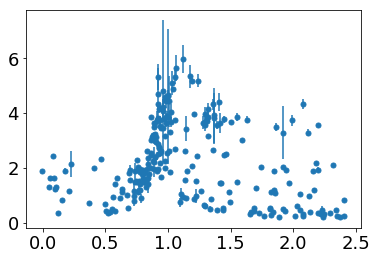

In [578]:
plt.scatter(hpjoin['bp_rp'],hpjoin['period'],s=25)
plt.errorbar(hpjoin['bp_rp'],hpjoin['period'],yerr=hpjoin['period_unc'],linestyle='none')

In [579]:
#(hpjoin['bp_rp'] > 1) & (hpjoin['bp_rp'] < 1.5) & (hpjoin['period'] < 0.2)

In [552]:
hpjoin[0]

source_id,period,period_unc,e_period_hwhm,e_period_mad,e_period_std,CDIPS,classification,ra,dec,l,b,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_n_obs,phot_g_mean_mag,bp_rp,proba,cluster
int64,float64,float64,float64,float64,float64,int64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str8
5289872972356315520,0.1404735587271196,0.008333177212625742,0.020832943031564355,0.0,0.008333177212625742,1,C,119.67760602546025,-61.638058241591146,274.6692956427792,-16.196032966608414,2.401245021539763,0.017618332072687985,-4.471179394158836,0.038342604630081094,11.718953987469009,0.03273623461535047,0.02789749,0.035600264,-0.16609408,0.048069436,0.18690306,0.10639049,-0.07866284,0.14349449,-0.20369785,0.09972408,414,14.170816,1.2062683,0.800000011920929,NGC_2516


In [580]:
np.median(np.abs(hpjoin['period_unc']/hpjoin['period']))

0.023032590526181878

(array([47., 34., 41., 29., 18., 25., 29., 13.,  7.,  2.]),
 array([0.22381208, 0.79871091, 1.37360974, 1.94850857, 2.52340739,
        3.09830622, 3.67320505, 4.24810388, 4.82300271, 5.39790153,
        5.97280036]),
 <a list of 10 Patch objects>)

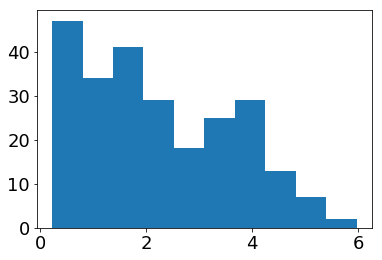

In [581]:
plt.hist(hpjoin['period'])

(array([34., 26., 28., 26., 17., 19., 25.,  9.,  4.,  2.]),
 array([0.14047356, 0.72370624, 1.30693892, 1.8901716 , 2.47340428,
        3.05663696, 3.63986964, 4.22310232, 4.806335  , 5.38956768,
        5.97280036]),
 <a list of 10 Patch objects>)

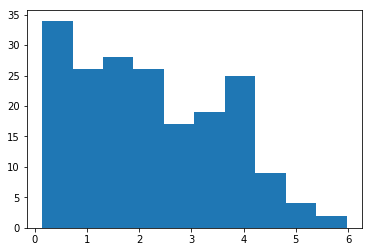

In [118]:
plt.hist(vetperiods[goodindx]['period'])

In [582]:
#memtbl=ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/CGmems_GES_Gaia_table.dat')
memtbl=ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NGC_2516_papertbls_singlestars_GESgalah_goodRV.dat')
ssmemtbl=ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NGC_2516_papertbls_singlestars.dat')

allmems = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NGC_2516_allCGmems.dat')

In [583]:
allmems_periods = join(allmems,vetperiods[goodindx])
#highprob = allmems_periods['proba'] > 0.5

In [584]:
allmems_periods#[highprob]

ra,dec,source_id,l,b,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_n_obs,phot_g_mean_mag,bp_rp,proba,cluster,period,period_unc,e_period_hwhm,e_period_mad,e_period_std,CDIPS,classification
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str8,float64,float64,float64,float64,float64,int64,str1
119.22520690444166,-61.566462151161225,5289888228079920640,274.5001890671572,-16.35435854673811,2.495637682666451,0.04000012541581146,-4.439889130493218,0.08857254683512848,11.36082243650047,0.08680214958760665,-0.1941937,-0.15609759,-0.25575122,0.28566957,0.12654856,0.29178885,-0.2997828,0.033962857,-0.14802706,-0.090075195,464,16.441534,2.3475647,0.800000011920929,NGC_2516,0.2482096272254628,0.01317590962709021,0.06249882699921727,0.0,0.01317590962709021,1,C
119.49936785349912,-61.45191965058128,5289890495822656640,274.45652443155785,-16.18563905846991,2.3928190531459097,0.01890695217759307,-4.393270268704721,0.039592181423995655,11.401475527243258,0.037162114672072595,0.012834066,0.034496877,-0.3020553,0.030143429,0.23014058,0.058823388,-0.2513722,0.08350046,-0.1359186,-0.007402256,455,12.709742,0.9228382,0.699999988079071,NGC_2516,1.9601555138693318,0.013176402047905867,0.43750813929364085,0.0,0.013176402047905867,1,C
119.98416898329307,-61.32024360559023,5289898020605414016,274.4470383089242,-15.91888146770759,2.362036220041,0.022592674318478393,-4.712546041542891,0.04576224817146788,11.733439840450455,0.04675409759308582,0.094471,0.051852487,-0.053004943,0.08687148,0.30354747,0.10655951,-0.2859684,0.06595268,-0.11679387,0.16156341,413,12.634859,0.8862591,0.8999999761581421,NGC_2516,2.2292090849950905,0.5520938388071954,0.5520938388071954,0.0,0.0,1,C
121.13929660975464,-61.34479131354677,5289930181318610432,274.7422043965664,-15.442528365609865,2.3884908308201847,0.03956593795486762,-5.996325742897152,0.07986416562888808,11.285662861416583,0.06402113272147258,-0.09037766,-0.3883745,-0.67335325,0.09366239,0.36055145,0.20421809,-0.3568515,0.5064942,-0.19008742,-0.045431316,264,10.764917,0.4116087,0.800000011920929,NGC_2516,2.010377542115748,0.025983226185360375,0.5104268584400415,0.06611682078975804,0.05311584717240069,1,C
120.8427489599831,-61.36651762040685,5289932277265953280,274.69131458647644,-15.577716599734591,2.292686353157289,0.024159550812773656,-6.055720429422538,0.06497465559259419,11.239899937689444,0.05410653887675045,0.17009483,-0.1389264,-0.6313321,-0.27126476,0.14911732,-0.2399939,-0.44563702,0.21363883,0.025198879,0.23059875,334,12.876329,0.9284153,0.699999988079071,NGC_2516,2.722673553108324,0.05204269183479503,0.6666800130042247,0.022903539758380224,0.05204269183479503,0,C
121.15734269335677,-61.250432702202865,5289934751163440000,274.6607323173441,-15.389518896548115,2.4388671345052253,0.026805866704714697,-5.4977469463723265,0.05465186967286327,11.431481500600079,0.04818195625532095,0.12255578,0.07034077,-0.07658734,-0.081400275,0.2666709,0.0258292,-0.31808743,0.35445124,-0.11345839,0.05156331,204,11.357195,0.59317017,0.800000011920929,NGC_2516,1.6380631029605859,0.021245497850816367,0.20832924637943506,0.022902631951581452,0.021245497850816367,1,C
121.28565505123679,-61.18736195636068,5289958425026796288,274.6343536109714,-15.304977045816903,2.4091882002309433,0.05364721138081558,-5.010441469558942,0.11122766528660019,11.31696637052315,0.10035107447776305,0.05425949,-0.031743843,-0.28042758,-0.047183275,0.22311863,0.0013237105,-0.23248485,0.20772423,-0.12612036,0.10145538,440,16.926434,2.1946259,0.699999988079071,NGC_2516,0.3386972844334585,0.008333500847220421,0.06250125635415316,0.0,0.008333500847220421,1,C
120.4673702071265,-61.448401815032604,5289972031483161600,274.6775935440635,-15.77470313

(array([47., 34., 41., 29., 18., 25., 29., 13.,  7.,  2.]),
 array([0.22381208, 0.79871091, 1.37360974, 1.94850857, 2.52340739,
        3.09830622, 3.67320505, 4.24810388, 4.82300271, 5.39790153,
        5.97280036]),
 <a list of 10 Patch objects>)

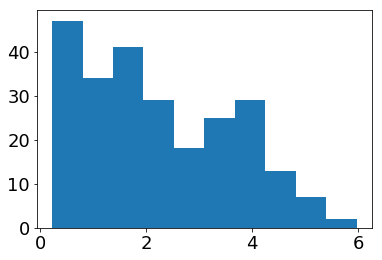

In [586]:
plt.hist(allmems_periods['period'])

In [587]:
ssmems_periods = join(ssmemtbl,vetperiods[goodindx])

ssmems_periods

ra,dec,source_id,l,b,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_n_obs,phot_g_mean_mag,bp_rp,proba,cluster,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,period,period_unc,e_period_hwhm,e_period_mad,e_period_std,CDIPS,classification
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str1
119.49936785349912,-61.45191965058128,5289890495822656640,274.45652443155785,-16.18563905846991,2.3928190531459097,0.01890695217759307,-4.393270268704721,0.039592181423995655,11.401475527243258,0.037162114672072595,0.012834066,0.034496877,-0.3020553,0.030143429,0.23014058,0.058823388,-0.2513722,0.08350046,-0.1359186,-0.007402256,455,12.709742,0.9228382,0.699999988079071,NGC_2516,3.1241972000000002,297.19097999999997,0.0,0.0,1.9601555138693318,0.013176402047905867,0.43750813929364085,0.0,0.013176402047905867,1,C
119.98416898329307,-61.32024360559023,5289898020605414016,274.4470383089242,-15.91888146770759,2.362036220041,0.022592674318478393,-4.712546041542891,0.04576224817146788,11.733439840450455,0.04675409759308582,0.094471,0.051852487,-0.053004943,0.08687148,0.30354747,0.10655951,-0.2859684,0.06595268,-0.11679387,0.16156341,413,12.634859,0.8862591,0.8999999761581421,NGC_2516,7.240514,376.11475,0.0,0.0,2.2292090849950905,0.5520938388071954,0.5520938388071954,0.0,0.0,1,C
121.13929660975464,-61.34479131354677,5289930181318610432,274.7422043965664,-15.442528365609865,2.3884908308201847,0.03956593795486762,-5.996325742897152,0.07986416562888808,11.285662861416583,0.06402113272147258,-0.09037766,-0.3883745,-0.67335325,0.09366239,0.36055145,0.20421809,-0.3568515,0.5064942,-0.19008742,-0.045431316,264,10.764917,0.4116087,0.800000011920929,NGC_2516,8.342107,304.49652000000003,0.0,1.2560739669470197e-15,2.010377542115748,0.025983226185360375,0.5104268584400415,0.06611682078975804,0.05311584717240069,1,C
121.15734269335677,-61.250432702202865,5289934751163440000,274.6607323173441,-15.389518896548115,2.4388671345052253,0.026805866704714697,-5.4977469463723265,0.05465186967286327,11.431481500600079,0.04818195625532095,0.12255578,0.07034077,-0.07658734,-0.081400275,0.2666709,0.0258292,-0.31808743,0.35445124,-0.11345839,0.05156331,204,11.357195,0.59317017,0.800000011920929,NGC_2516,9.478527,401.3126,0.0,0.0,1.6380631029605859,0.021245497850816367,0.20832924637943506,0.022902631951581452,0.021245497850816367,1,C
121.28565505123679,-61.18736195636068,5289958425026796288,274.6343536109714,-15.304977045816903,2.4091882002309433,0.05364721138081558,-5.010441469558942,0.11122766528660019,11.31696637052315,0.10035107447776305,0.05425949,-0.031743843,-0.28042758,-0.047183275,0.22311863,0.0013237105,-0.23248485,0.20772423,-0.12612036,0.10145538,440,16.926434,2.1946259,0.699999988079071,NGC_2516,0.79059106,238.37921,0.0,0.0,0.3386972844334585,0.008333500847220421,0.06250125635415316,0.0,0.008333500847220421,1,C
120.4673702071265,-61.448401815032604,5289972031483161600,274.6775935440635,-15.774703138795028,2.517920407644222,0.02141521997580132,-4.400499687065648,0.04698595190238245,11.347170910310595,0.04675137295871833,-0.024750622,-0.12834029,-0.30896422,-0.0018503856,0.18850622,0.029727736,-0.49012598,0.03650391,0.12352677,-0.02820189,394,12.753855,0.89847565,0.6000000238418579,NGC_2516,4.271561599999999,291.2335,0.0,0.0,2.97862923895674,0.07839688706630499,0.708347081206739,0.06871057731139041,0.07839688706630499,1,C
120.60754413916358,-61.251825720989636,5289978010077507328,274.530789427336,-15.622435916534718,2.3816840275859468,0.016162638360208096,-4.717329565412189,0.03583035361571449,10.707286781711897,0.037379339

(19, 5)

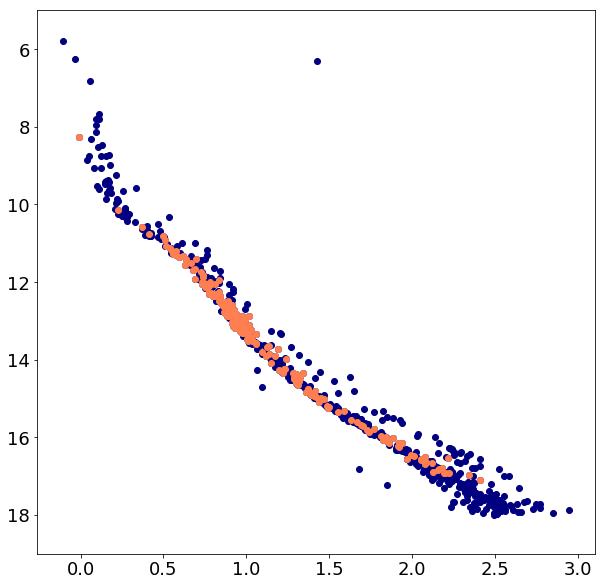

In [588]:
plt.figure(figsize=(10,10))
plt.scatter(mems[highprob]['bp_rp'],mems[highprob]['phot_g_mean_mag'],color='navy')
plt.scatter(ssmems_periods['bp_rp'],ssmems_periods['phot_g_mean_mag'],color='coral')
plt.ylim(19,5)

(array([32., 22., 34., 23., 15., 25., 24., 11.,  7.,  1.]),
 array([0.22440884, 0.79924799, 1.37408715, 1.9489263 , 2.52376545,
        3.0986046 , 3.67344375, 4.24828291, 4.82312206, 5.39796121,
        5.97280036]),
 <a list of 10 Patch objects>)

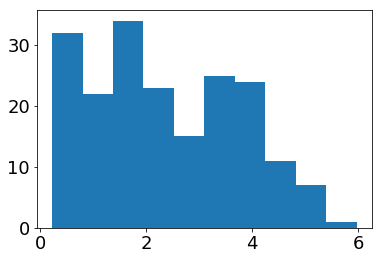

In [589]:
plt.hist(ssmems_periods['period'])

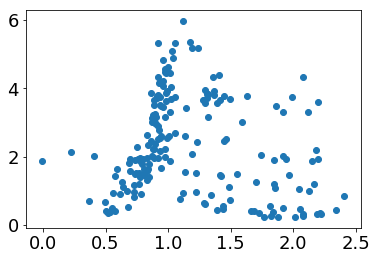

In [590]:
plt.scatter(ssmems_periods['bp_rp'],ssmems_periods['period'])

In [591]:
np.sum((memtbl['vsini'] > 5) & (memtbl['proba'] > 0.5))

110

In [592]:
mems_periods = join(memtbl,vetperiods[goodindx])
mems_periods.sort('logTeff')

mems_periods

ra,dec,source_id,l,b,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_n_obs,phot_g_mean_mag,bp_rp,proba,Cluster,Object,Icmag,Jmag,Hmag,Kmag,S/N,RV,vsini,logTeff,Nsp,pRV,pvsini,gaia_r,parallax_err,cluster,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,Survey,star_id,sobject_id,ndfclass,field_id,raj2000,dej2000,jmag,hmag,kmag,vmag_jk,e_jmag,e_hmag,e_kmag,snr_c1,snr_c2,snr_c3,snr_c4,rv_synt,e_rv_synt,rv_obst,e_rv_obst,rv_nogr_obst,e_rv_nogr_obst,chi2_cannon,sp_label_distance,flag_cannon,teff,e_teff,logg,e_logg,fe_h,e_fe_h,vmic,e_vmic,e_vsini,alpha_fe,e_alpha_fe,li_fe,e_li_fe,flag_li_fe,c_fe,e_c_fe,flag_c_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,y_fe,e_y_fe,flag_y_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,eu_fe,e_eu_fe,flag_eu_fe,period,period_unc,e_period_hwhm,e_period_mad,e_period_std,CDIPS,classification
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str7,str16,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,str8,float64,float64,float64,float64,str5,str16,int64,str8,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,int64,str1
118.96738202201645,-60.900954075464966,5290717156769863296,273.8242496955609,-16.161456456113402,2.4058211084230536,0.061830053756787566,-3.772999705554593,0.14194758551742004,11.19573449580076,0.1170119332730182,0.014870356,-0.013793658,-0.18844959,0.028962325,0.29360867,0.060972344,-0.35829064,0.11112154,-0.040346175,0.076971464,386,16.925892,2.2192764,0.800000011920929,NGC2516,07555219-6054036,0.0,14.34,13.57,13.38,27.29,26.19,79.2,3.551,2,1.54,0.06,0.5966528058052063,0.061830053756787566,NGC_2516,2.3773413,265.15982,0.23110363065781456,1.5535992224973016,GES,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,3556.3131856898544,130.31561691791333,--,--,--,--,--,--,4.752,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.3124964190647005,0.052082736510783434,0.052082736510783434,0.0,0.0,1,C
119.23477768044064,-61.01592919157621,5290665204845694336,273.9924563522617,-16.098536078476037,2.458022835975593,0.02839492201904915,-4.225825531395757,0.056428388851406046,10.899937613299397,0.05724240426432102,-0.05445077,-0.10038883,-0.1786884,0.15465733,0.20828745,0.18859716,-0.20497853,0.15496665,-0.08978485,-0.010322434,400,15.778953,1.7705164,0.6000000238418579,NGC2516,07565636-6100575,0.0,13.7,12.95,12.73,42.55,24.38,105.5,3.556,2,

(8000, 3000)

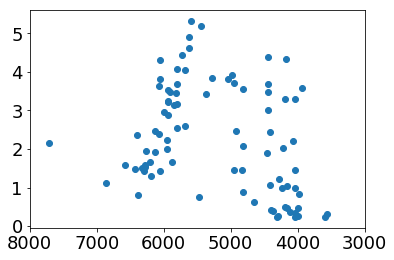

In [593]:
plt.scatter(mems_periods['teff'],mems_periods['period'])
plt.xlim(8000,3000)

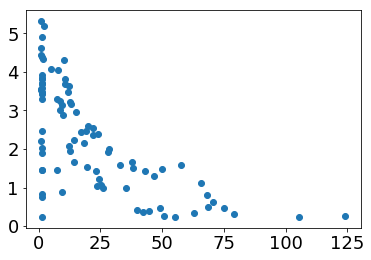

In [595]:
plt.scatter(mems_periods['vsini'],mems_periods['period'])

In [601]:
mems_periods[(mems_periods['vsini']>5) & (mems_periods['teff'] > 4000) & (mems_periods['teff'] < 10000)]

ra,dec,source_id,l,b,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_n_obs,phot_g_mean_mag,bp_rp,proba,Cluster,Object,Icmag,Jmag,Hmag,Kmag,S/N,RV,vsini,logTeff,Nsp,pRV,pvsini,gaia_r,parallax_err,cluster,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,Survey,star_id,sobject_id,ndfclass,field_id,raj2000,dej2000,jmag,hmag,kmag,vmag_jk,e_jmag,e_hmag,e_kmag,snr_c1,snr_c2,snr_c3,snr_c4,rv_synt,e_rv_synt,rv_obst,e_rv_obst,rv_nogr_obst,e_rv_nogr_obst,chi2_cannon,sp_label_distance,flag_cannon,teff,e_teff,logg,e_logg,fe_h,e_fe_h,vmic,e_vmic,e_vsini,alpha_fe,e_alpha_fe,li_fe,e_li_fe,flag_li_fe,c_fe,e_c_fe,flag_c_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,y_fe,e_y_fe,flag_y_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,eu_fe,e_eu_fe,flag_eu_fe,period,period_unc,e_period_hwhm,e_period_mad,e_period_std,CDIPS,classification
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str7,str16,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,str8,float64,float64,float64,float64,str5,str16,int64,str8,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,int64,str1
119.87081758061746,-60.66154951640272,5290817212328531072,273.8151281667631,-15.659740000326625,2.4428402085346916,0.060982685192413774,-4.24202014032291,0.14022216642495422,11.403361044437947,0.11718587294606186,0.028103054,-0.077069566,-0.062218517,-0.10782438,0.29826143,-0.1203614,0.12512742,0.15014581,-0.0012410679,-0.12329462,377,16.676176,2.0760937,0.8999999761581421,NGC2516,07592900-6039417,0.0,14.22,13.53,13.3,29.12,22.27,62.8,3.606,2,1.12,0.06,0.5437974333763123,0.060982685192413774,NGC_2516,1.4348531,189.56548999999998,0.16347142333845854,0.914656713637061,GES,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,4036.4539296760486,138.6144893432709,--,--,--,--,--,--,3.768,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.33332941681146616,0.07291580992750823,0.07291580992750823,0.0,0.0,1,C
119.62997956802782,-61.08969061592808,5290655687198404864,274.1522684188541,-15.962756765003558,2.4652637482422928,0.06032916823415625,-4.695146958604306,0.12255809954780116,11.236194643186431,0.10766447681122257,0.022072649,0.11788812,-0.12629795,0.030659784,0.2522723,0.09911209,-0.09510061,0.1812259,-0.19569308,-0.0646742,420,16.89682,2.127181,0.800000011920929,NGC2516,07583121-6105232,0.0,14.38,13.66,13.42,25.33,23.34,26.2,3.606,2,

NameError: name 'deltaM' is not defined

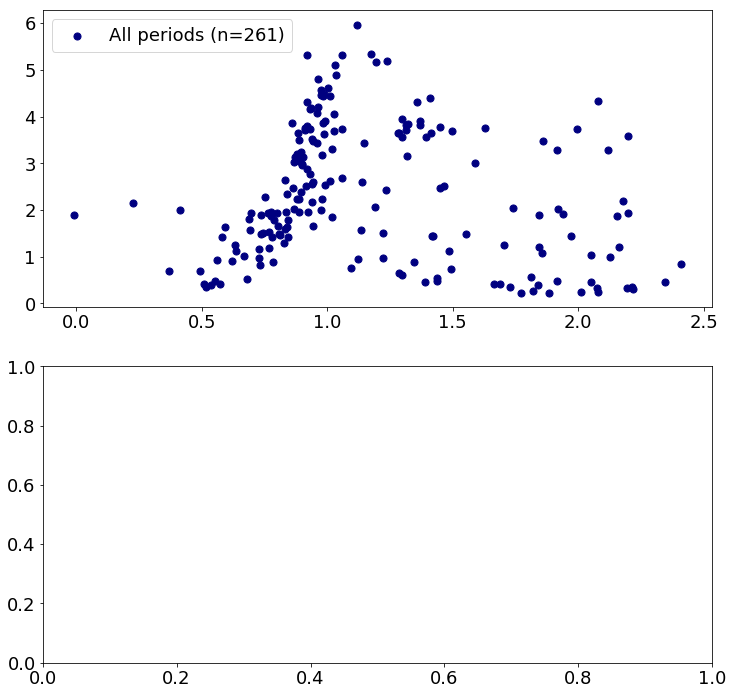

In [594]:
#gvsini = joinperiods['vsini']>5
#bright = joinallperiods['phot_g_mean_mag'] <= 20
rfig,ax = plt.subplots(2,1,figsize=(12,12))
ax[0].scatter(ssmems_periods['bp_rp'],ssmems_periods['period'],color='navy',s=50,label='All periods (n=261)')
ax[0].legend(loc=2)

ax[0].errorbar(ssmems_periods['bp_rp'],ssmems_periods['period'],xerr=deltaM,yerr=ssmems_periods['period_unc'],linestyle='none',color='navy')
#plt.xlim(3500,8000)
ax[0].set_ylim(-0.1,7.1)

#ax[0].set_xlabel('$B_{p} - R_{p}$ color')
ax[0].set_xlabel(r'$G_{\rm BP} - G_{\rm RP}$ color')
ax[0].set_ylabel('Period [d]')

gvsini = mems_periods['vsini']>0
ax[1].scatter(mems_periods['teff'],mems_periods['period'],color='tomato',s=50,label=r'Single stars w/meas. T$_{\rm eff}$ (n=75)')
ax[1].legend(loc=2)

ax[1].errorbar(mems_periods['teff'],mems_periods['period'],yerr=mems_periods['period_unc'],xerr=mems_periods['e_teff'],linestyle='none',color='tomato')
ax[1].set_xlim(7200,3300)
ax[1].set_ylim(-0.1,7.1)
ax[1].set_xlabel(r'T$_{\rm eff}$ [K]')
ax[1].set_ylabel('Period [d]')

#rfig.savefig('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperfigs/rotperiods_bprp.pdf',bbox_inches='tight')


In [2804]:
5290840233352691968 in mems_periods[vsini_indx]['source_id']

False

In [32]:
vsini_indx = mems_periods['vsini'] > 5
np.sum(vsini_indx)

93

In [2801]:
mems_periods[vsini_indx].write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/mems_periods_vsini5.dat',format='ascii')

In [2800]:
mems_periods.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/mems_periods_allvsini.dat',format='ascii')

In [2610]:
extinctbl.rename_column('objname','source_id')


KeyError: 'Column objname does not exist'

In [2622]:
from astropy.table import Column
extinctbl.replace_column('source_id',Column(data=extinctbl['source_id'],name='source_id',dtype=np.int))

In [2623]:
join(mems_periods,extinctbl)

ra,dec,source_id,l,b,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_n_obs,phot_g_mean_mag,bp_rp,proba,cluster,Cluster,Object,Icmag,Jmag,Hmag,Kmag,S/N,RV,vsini,logTeff,Nsp,pRV,pvsini,gaia_r,parallax_err,period,period_unc,classification,cutout_size,E_B_V_SandF,mean_E_B_V_SandF,stdev_E_B_V_SandF,max_E_B_V_SandF,min_E_B_V_SandF,AV_SandF,E_B_V_SFD,mean_E_B_V_SFD,stdev_E_B_V_SFD,max_E_B_V_SFD,min_E_B_V_SFD,AV_SFD,errmsg
deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,mags,mags,mags,mags,mags,mags,mags,mags,mags,mags,mags,mags,
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str8,str7,str16,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1


In [2626]:
extinctbl

source_id,ra,dec,cutout_size,E_B_V_SandF,mean_E_B_V_SandF,stdev_E_B_V_SandF,max_E_B_V_SandF,min_E_B_V_SandF,AV_SandF,E_B_V_SFD,mean_E_B_V_SFD,stdev_E_B_V_SFD,max_E_B_V_SFD,min_E_B_V_SFD,AV_SFD,errmsg
,deg,deg,deg,mags,mags,mags,mags,mags,mags,mags,mags,mags,mags,mags,mags,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1
5289889946066884608,119.64283,-61.45219,5.0,0.1969,0.1938,0.0032,0.1995,0.1848,0.6103,0.2289,0.2254,0.0038,0.232,0.2149,0.7096,--
5289864726018908160,119.1935,-61.58236,5.0,0.2031,0.2021,0.004,0.2101,0.1951,0.6297,0.2362,0.235,0.0047,0.2443,0.2269,0.7322,--
5289891423535761408,119.86336,-61.51637,5.0,0.1866,0.1863,0.0039,0.1938,0.1798,0.5785,0.217,0.2166,0.0045,0.2254,0.2091,0.6727,--
5289894515912156160,119.98138,-61.40386,5.0,0.182,0.1836,0.0049,0.191,0.1724,0.5641,0.2116,0.2135,0.0057,0.2221,0.2005,0.6559,--
5289881768449288192,120.05924,-61.45287,5.0,0.1768,0.1788,0.0043,0.1861,0.1713,0.5479,0.2055,0.2079,0.005,0.2164,0.1991,0.6371,--
5289893004083665920,119.94307,-61.42872,5.0,0.1857,0.1844,0.0045,0.1915,0.1759,0.5758,0.216,0.2144,0.0052,0.2227,0.2045,0.6695,--
5289873315953700864,119.72948,-61.62893,5.0,0.1909,0.1892,0.0027,0.1949,0.183,0.5919,0.222,0.2201,0.0031,0.2266,0.2128,0.6882,--
5289872972356315136,119.67761,-61.63806,5.0,0.1915,0.1906,0.0026,0.1962,0.1862,0.5937,0.2227,0.2216,0.0031,0.2282,0.2165,0.6903,--


In [2565]:
radius_names = mems_periods['source_id']


In [2566]:
import glob
sedfiles = []
for i in range(len(radius_names)):
    dummy = glob.glob('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/SEDfiles/*'+np.str(radius_names[i])+'*')
    sedfiles += dummy

In [2567]:
for i in range(len(sedfiles)):
    sedfiles[i] = 'cp ' + sedfiles[i] + ' /Users/bhealy/Documents/PhD_Thesis/NGC_2516/SEDfiles_EC2/.\n'


In [2781]:
for i in range(len(radius_names)):
    #print('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/argfiles/gaia_dr2_'+np.str(radius_names[i])+'.args')
    file = open('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/argfiles_nomist/gaia_dr2_'+np.str(radius_names[i])+'.args',mode='w+')
    pfline = 'priorfile=$EXOFAST_PATH/ngc2516/priorfiles/gaia_dr2_'+np.str(radius_names[i])+'.priors\n'
    file.write(pfline)
    pfxline = 'prefix=$EXOFAST_PATH/ngc2516/fitresults/gaia_dr2_'+np.str(radius_names[i])+'.\n'
    file.write(pfxline)
    flxline = 'fluxfile=$EXOFAST_PATH/ngc2516/SEDfiles/*_'+np.str(radius_names[i])+'.sed\n'
    file.write(flxline)
    file.write('nplanets=0\n')
    file.write('maxsteps=75000\n')
    file.write('nthin=1\n')
    file.write('/nomist')
    file.close()
    

In [2592]:
from astroquery.mast import Catalogs

In [2601]:
qry = Catalogs.query_object('Gaia DR2 '+np.str(mems_periods['source_id'][0]),catalog='TIC')
qry[0]

ID,ra,dec,pmRA,pmDEC,Tmag,objType,typeSrc,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,POSflag,e_pmRA,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,TWOMflag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,e_Tmag,TESSflag,SPFlag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lumclass,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,disposition,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,dstArcSec
str11,float64,float64,float64,float64,float64,str8,str7,str8,str5,str12,str10,str16,str1,str19,str19,str8,str1,str8,float64,float64,str5,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,int64,float64,str5,str9,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,str5,float64,float64,float64,float64,int64,str1,str8,str8,str13,float64,float64,float64,float64,float64,float64,int64,int64,float64
358464734,118.989483062111,-60.6954926670871,-3.99164,10.6838,16.3309,STAR,tmgaia2,20190415,--,--,--,07555748-6041437,--,J075557.43-604143.5,5290740040355375360,--,--,tmgaia2,0.260789,0.208356,gaia2,2.31666,0.113119,gaia2,273.639050178367,-16.0581581274191,169.042878115825,-76.0180124118511,19.411,0.181,18.5491,0.0502,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,14.845,0.032,14.173,0.022,13.945,0.054,AAA-222-111-000-0-0,nan,13.71,0.025,13.572,0.027,12.758,nan,8.985,nan,17.5136,0.001425,0.0088931,cdwrf,cdwrf,3486.0,157.0,4.75779,0.0171966,nan,nan,0.476794,0.0234798,0.474658,0.0279598,4.37914,0.39048,DWARF,0.03024585,0.008488247,427.774,21.268,0.109415,0.003235555,--,nan,--,--,nan,0.0031548,0.00331631,schlegel,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,20.231,22.305,bj2018,nan,nan,cdwrf,18.783,0.023557,16.3785,0.005306,1,--,gaia2,bpbj,cooldwarfs_v8,4.68544752609765,3.23159153902647,118.989447948839,-60.6954466673969,0.113779269919265,0.115746977426794,1,0,7.6119079134014e-07


In [2603]:
qry[0]['rad']

0.476794

In [2627]:
extinctbl = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/extinction.dat')


In [2779]:
k = 1.08

for i in range(len(mems_periods)):
    #if mems_periods['source_id'][i] == 5290721142499618816:
    #print('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/argfiles/gaia_dr2_'+np.str(radius_names[i])+'.args')
    
    pfile = open('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/priorfiles_new/gaia_dr2_'+np.str(radius_names[i])+'.priors',mode='w+')
    teff = 10**mems_periods[i]['logTeff']
    teff_unc = 2*(teff / mems_periods[i]['S/N'])
    print(teff,teff_unc,teff_unc/teff*100)

    pfile.write('teff '+np.str(teff)+' '+np.str(teff_unc)+'\n')

        #qry = Catalogs.query_object('Gaia DR2 '+np.str(mems_periods['source_id'][i]),catalog='TIC')
    #qry = Catalogs.query_region(np.str(mems_periods['ra'][i])+', '+np.str(mems_periods['dec'][i]),catalog='TIC')
    #if np.isnan(mems_periods['gaia_r'][i]):
    #    rad = qry[0]['rad']
    #else:
    #    rad = mems_periods[i]['gaia_r']
    #print(qry[0]['GAIA'] == np.str(mems_periods['source_id'][i]))

        
    #mass = qry[0]['mass']

    #pfile.write('mstar ' + np.str(mass) +'\n')

    #pfile.write('rstar '+np.str(rad)+'\n')

    pfile.write('age ' + np.str(0.135) + ' ' + np.str(0.015)+'\n')

    extindx = extinctbl['objname'] == np.str(mems_periods['source_id'][i])
    av = extinctbl[extindx]['E_B_V_SandF'].data[0] * 3.1
    #av_err = np.mean((extinctbl[extindx]['max_E_B_V_SandF'].data *3.1 - av, av - extinctbl[extindx]['min_E_B_V_SandF'].data *3.1))*2
    av_err = extinctbl[extindx]['stdev_E_B_V_SandF'].data[0] * 3.1 * 2
    print(av,av_err,av_err/av*100)

    pfile.write('av ' + np.str(av) + ' ' + np.str(av_err)+'\n')

    plx = mems_periods['parallax'][i]
    plx_err = mems_periods['parallax_error'][i]
    if mems_periods['phot_g_mean_mag'][i] <= 13:
        sig = 0.021
    else:
        sig = 0.043
    plx_err = np.sqrt(k**2*plx_err**2 + sig**2)

    pfile.write('parallax ' + np.str(plx) + ' ' + np.str(plx_err) + '\n')

    print(plx,plx_err,plx_err/plx*100)
    print()

    pfile.write('feh -0.05 0.1')


    pfile.close()


    
    
    
    
    
    

3655.9479161312506 576.1935250009851 15.760441292356187
0.53289 0.03162 5.9336823734729505
2.3166589904364097 0.1295148993502695 5.590589719286722

3854.783576657717 391.5473414583765 10.157440325038088
0.62186 0.07502 12.06380857427717
2.5459269293995757 0.0897341318737758 3.524615370439498

3881.5036599064824 388.73346618993315 10.015022533800702
0.5093300000000001 0.03286 6.451612903225806
2.343589368965242 0.07380192531805177 3.1490979731930304

4036.4539296760486 318.70935094165407 7.895775759968417
0.55304 0.01984 3.587443946188341
2.4652637482422928 0.07806560959124081 3.166623029560256

4073.802778041126 282.3148148330649 6.93000693000693
0.58497 0.0403 6.889242183359831
2.5482974051877796 0.06942553725415276 2.724389120077486

4083.1938633269233 252.82934138247205 6.191950464396285
0.6559600000000001 0.0589 8.979206049149337
2.4494445115613983 0.07435304913384759 3.0355065723228507

4159.106104940223 779.5887731846717 18.744142455482663
0.5592400000000001 0.02356 4.21286031042

In [ ]:
#idl -arg $EXOFAST_PATH/ngc2516/argfiles/gaia_dr2_5291030448862535808.args -vm=$EXOFAST_PATH/exofastv2.sav

In [2701]:
nmax = 7
count = 0
ind = 1
maxind = 9

sfile = open('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/shellfiles/group_fit_'+np.str(ind)+'.sh',mode='w')

for i in range(len(mems_periods)):
    if (len(mems_periods) - i) < 7:
        #ind += 1
        #count=0
        #ind = maxind
        #if count == 0:
        sfile = open('/Users/bhealy/Documents/PhD_Thesis/NGmerger = PdfFileMerger()
num = 200
fcount = 0
indx = 0
bins = np.int(np.ceil(len(sortfiles)/num))
for i in range(len(sortfiles)):
        merger.append(PdfFileReader(sortfiles[i],'rb'))
        fcount += 1
        if (fcount == 200) or ((len(sortfiles)-i) == 1):
            merger.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NGC_2516_newf_merged_DVRs_'+np.str(indx)+'.pdf')
            indx += 1
            fcount = 0
            merger = PdfFileMerger()C_2516/shellfiles/group_fit_'+np.str(ind)+'.sh',mode='a+')
        #else:
        #    sfile = open('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/shellfiles/group_fit_'+np.str(ind)+'.sh',mode='a')
        sfile.write('idl -arg $EXOFAST_PATH/ngc2516/argfiles/gaia_dr2_'+np.str(mems_periods['source_id'][i])+'.args -vm=$EXOFAST_PATH/exofastv2.sav\n')
        #count += 1
        print(i, mems_periods['source_id'][i])
        #break
    elif count < nmax:
        #if count == 0:
        sfile = open('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/shellfiles/group_fit_'+np.str(ind)+'.sh',mode='a+')
        #else:
        #    sfile = open('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/shellfiles/group_fit_'+np.str(ind)+'.sh',mode='a')
        sfile.write('idl -arg $EXOFAST_PATH/ngc2516/argfiles/gaia_dr2_'+np.str(mems_periods['source_id'][i])+'.args -vm=$EXOFAST_PATH/exofastv2.sav\n')
        count += 1
        print(i, mems_periods['source_id'][i])
        #sfile.close()
    else:
        ind += 1
        sfile = open('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/shellfiles/group_fit_'+np.str(ind)+'.sh',mode='a+')
        sfile.write('idl -arg $EXOFAST_PATH/ngc2516/argfiles/gaia_dr2_'+np.str(mems_periods['source_id'][i])+'.args -vm=$EXOFAST_PATH/exofastv2.sav\n')
        #sfile.close()
        #ind += 1
        count = 0
        print(i, mems_periods['source_id'][i])

        
sfile.close()
        

0 5290740040355375360
1 5290897751553047552
2 5290932386169704320
3 5290655687198404864
4 5290718084482964992
5 5290894727896572160
6 5290653075858442752
7 5290642046382523008
8 5290829650553566208
9 5290717843964557056
10 5290703069277036928
11 5290755193001408128
12 5290673348103622272
13 5290934997509679232
14 5290717672165866496
15 5290933863638628096
16 5290815734859774080
17 5290758933911651584
18 5290819342632176512
19 5290732721731067136
20 5290840233352691968
21 5290769314853433600
22 5290837755153683840
23 5290710903297629824
24 5290653350736340736
25 5290769039975605760
26 5290721726615163648
27 5290772029272852864
28 5290703687752332544
29 5290762752143565184
30 5290816731292063872
31 5290817281048004736
32 5290742411177350144
33 5290713445918199168
34 5290745881512256000
35 5290719836829549056
36 5290721864054120320
37 5290725781064133760
38 5290713652076611200
39 5290820785740950656
40 5290664861248309760
41 5290667713106775040
42 5290737669533445248
43 529074797745631488

In [2702]:
'''
merger = PdfFileMerger()
num = 200
fcount = 0
indx = 0
bins = np.int(np.ceil(len(sortfiles)/num))
for i in range(len(sortfiles)):
        merger.append(PdfFileReader(sortfiles[i],'rb'))
        fcount += 1
        if (fcount == 200) or ((len(sortfiles)-i) == 1):
            merger.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NGC_2516_newf_merged_DVRs_'+np.str(indx)+'.pdf')
            indx += 1
            fcount = 0
            merger = PdfFileMerger()
'''

"\nmerger = PdfFileMerger()\nnum = 200\nfcount = 0\nindx = 0\nbins = np.int(np.ceil(len(sortfiles)/num))\nfor i in range(len(sortfiles)):\n        merger.append(PdfFileReader(sortfiles[i],'rb'))\n        fcount += 1\n        if (fcount == 200) or ((len(sortfiles)-i) == 1):\n            merger.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NGC_2516_newf_merged_DVRs_'+np.str(indx)+'.pdf')\n            indx += 1\n            fcount = 0\n            merger = PdfFileMerger()\n"

In [2726]:
nmax = 3
count = 0
ind = 1
imax = np.int(np.ceil(len(mems_periods)/nmax))

sfile = open('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/shellfiles_2/group_fit_'+np.str(ind)+'.sh',mode='a+')
for i in range(len(mems_periods)):
    sfile.write('idl -arg $EXOFAST_PATH/ngc2516/argfiles/gaia_dr2_'+np.str(mems_periods['source_id'][i])+'.args -vm=$EXOFAST_PATH/exofastv2.sav\n')
    count += 1
    print(i, mems_periods['source_id'][i])
    if (count == nmax) or ((len(mems_periods) - i) == 1):
        sfile.close()
        ind += 1
        count = 0
        if ind <= imax:
            sfile = open('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/shellfiles_2/group_fit_'+np.str(ind)+'.sh',mode='a+')
        #sfile.write('idl -arg $EXOFAST_PATH/ngc2516/argfiles/gaia_dr2_'+np.str(mems_periods['source_id'][i])+'.args -vm=$EXOFAST_PATH/exofastv2.sav\n')

sfile.close()
    

0 5290740040355375360
1 5290897751553047552
2 5290932386169704320
3 5290655687198404864
4 5290718084482964992
5 5290894727896572160
6 5290653075858442752
7 5290642046382523008
8 5290829650553566208
9 5290717843964557056
10 5290703069277036928
11 5290755193001408128
12 5290673348103622272
13 5290934997509679232
14 5290717672165866496
15 5290933863638628096
16 5290815734859774080
17 5290758933911651584
18 5290819342632176512
19 5290732721731067136
20 5290840233352691968
21 5290769314853433600
22 5290837755153683840
23 5290710903297629824
24 5290653350736340736
25 5290769039975605760
26 5290721726615163648
27 5290772029272852864
28 5290703687752332544
29 5290762752143565184
30 5290816731292063872
31 5290817281048004736
32 5290742411177350144
33 5290713445918199168
34 5290745881512256000
35 5290719836829549056
36 5290721864054120320
37 5290725781064133760
38 5290713652076611200
39 5290820785740950656
40 5290664861248309760
41 5290667713106775040
42 5290737669533445248
43 529074797745631488

In [2732]:
files = glob.glob('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/fitresults/logs/*.log')

In [2752]:
incompl = np.zeros(len(files),)
for i in range(len(files)):
    o = open(files[i])
    rd = o.read()
    incompl[i] = ('0.00%' in rd) & ('100.00%' in rd)

In [2754]:
np.sum(incompl)/len(incompl)

0.4444444444444444

In [2768]:
compl = np.where(incompl == False)

In [2775]:
compl[0]


array([ 0,  3,  7,  9, 10, 11, 15, 18, 19, 21, 23, 24, 25, 26, 27, 28, 30,
       32, 34, 35])

In [2778]:
files[compl[0]]

TypeError: only integer scalar arrays can be converted to a scalar index

In [2774]:
file1 = open('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/sedcp.sh',mode='w+')

In [2570]:
file1.writelines(sedfiles)

In [2571]:
file1.close()

In [2515]:
tgtindx = (mems_periods['vsini'] >= 5) #& (mems_periods['proba'] >= 0.6)

In [2517]:
mems_periods[tgtindx]

ra,dec,source_id,l,b,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_n_obs,phot_g_mean_mag,bp_rp,proba,cluster,Cluster,Object,Icmag,Jmag,Hmag,Kmag,S/N,RV,vsini,logTeff,Nsp,pRV,pvsini,gaia_r,parallax_err,period,period_unc,classification
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str8,str7,str16,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,str1
118.29291337270324,-60.77773686876484,5290897751553047552,273.5551310285064,-16.39905579041275,2.5459269293995757,0.07292637750234145,-3.332661556140025,0.17287438196253657,12.159811515842165,0.18574672874681414,0.14400537,-0.032819834,-0.23229983,-0.014304838,0.022327749,-0.014297867,-0.5166578,0.118219,0.014029905,0.2058887,373,17.448193,2.4136353,0.10000000149011612,NGC_2516,NGC2516,07531031-6046400,0.0,14.69,13.99,13.72,19.69,23.4,7.8,3.586,2,0.34,0.14,nan,0.07292637750234145,2.1083551159696077,0.032390182765597075,C
119.19190680309721,-60.40359453677332,5290932386169704320,273.4167013744141,-15.835884643939078,2.343589368965242,0.05553799244490907,-4.36855600530728,0.11703791392683219,10.9239594669587,0.11757499691338812,-0.13186802,-0.010063716,-0.1066572,-0.0028674707,0.25411776,0.0363327,-0.19039418,0.10563692,0.12614341,-0.27248386,405,16.695633,2.0964289,0.4000000059604645,NGC_2516,NGC2516,07564607-6024132,0.0,14.36,13.63,13.33,19.97,24.05,10.0,3.589,4,0.33,0.11,0.6332019567489624,0.05553799244490907,1.4678843714299934,0.008333487915660952,C
119.62997956802782,-61.08969061592808,5290655687198404864,274.1522684188541,-15.962756765003558,2.4652637482422928,0.06032916823415625,-4.695146958604306,0.12255809954780116,11.236194643186431,0.10766447681122257,0.022072649,0.11788812,-0.12629795,0.030659784,0.2522723,0.09911209,-0.09510061,0.1812259,-0.19569308,-0.0646742,420,16.89682,2.127181,0.800000011920929,NGC_2516,NGC2516,07583121-6105232,0.0,14.38,13.66,13.42,25.33,23.34,26.2,3.606,2,0.49,0.06,0.5419772863388062,0.06032916823415625,0.9970427529463318,0.004166745833208552,C
119.22997168702376,-60.969919354916634,5290718084482964992,273.94878829388,-16.07951268415351,2.5482974051877796,0.05046852860089166,-4.65115274607963,0.11021781745939102,11.359942945121878,0.10958906103226444,0.010520145,-0.20693088,-0.15710565,0.11838374,0.20013113,0.10771258,-0.018842787,-0.04159204,-0.14066505,0.13409315,359,16.549444,2.0585766,0.6000000238418579,NGC_2516,NGC2516,07565520-6058118,0.0,14.23,13.4,13.24,28.86,21.59,5.0,3.61,2,0.29,0.21,0.5526226162910461,0.05046852860089166,2.3405197936718776,0.04580701587123928,C
118.24967790974463,-60.89129975872747,5290894727896572160,273.65122347243886,-16.468667317112573,2.4494445115613983,0.05616468469458247,-4.120028123141467,0.13381741510028874,11.40888475496453,0.13625526170732263,0.09358867,-0.22009508,-0.035087362,0.011308457,0.026438922,0.044463042,-0.47496992,-0.04324555,0.0888596,0.09825305,340,16.717352,2.130371,0.800000011920929,NGC_2516,NGC2516,07525994-6053288,0.0,14.26,13.51,13.29,32.3,23.24,5.2,3.611,2,0.28,0.19,nan,0.05616468469458247,5.641767229976541,0.0647808509527586,C
119.62662452597256,-61.168576005207235,5290653075858442752,274.22422386291186,-16.00070990601393,2.4852013772353576,0.024379217565162793,-4.110094823056237,0.04852623351704215,10.788076314657793,0.040559134161769386,0.17108783,0.22939928,-0.18688472,0.03279104,0.34856045,0.12190557,-0.2079526,0.19214812,-0.09254736,0.06974314,386,15.026208,1.4376688,0.800000011920929,NGC_2516,NGC2516,07583040-6110071,0.0,13.21,12.62,12.5,10.67,26.57,75.0,3.619,2,4.03,0.12,0.6558167338371277,0.024379217565162793,0.4738185278931008,0.0041667458483061635,C
119.57602414533608,-61.35245976984503,529064

In [2477]:
oneindx = mems_periods[tgtindx]['source_id'] == 5291030448862535808

In [2480]:
mems_periods[tgtindx][oneindx]

ra,dec,source_id,l,b,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,phot_g_n_obs,phot_g_mean_mag,bp_rp,proba,cluster,Cluster,Object,Icmag,Jmag,Hmag,Kmag,S/N,RV,vsini,logTeff,Nsp,pRV,pvsini,gaia_r,parallax_err,period,period_unc,classification
float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,str8,str7,str16,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,str1
119.23937225765353,-60.298828098950274,5291030448862535808,273.33131325218216,-15.76677004886915,2.4079950181013783,0.020841360597761233,-4.144574634387727,0.04176853324190522,11.068823679953411,0.037963544036613096,0.014360002,0.09923121,-0.24298535,0.05994794,0.4132529,0.07343005,-0.31524846,0.027584342,0.02949818,-0.07384287,400,12.354486,0.7990818,0.699999988079071,NGC_2516,NGC2516,07565746-6017559,0.0,11.33,11.13,11.03,123.73,25.77,27.9,3.787,2,0.31,0.05,1.1655031442642212,0.020841360597761233,1.9893227634293644,0.005103198672761402,C


(18.5, 5)

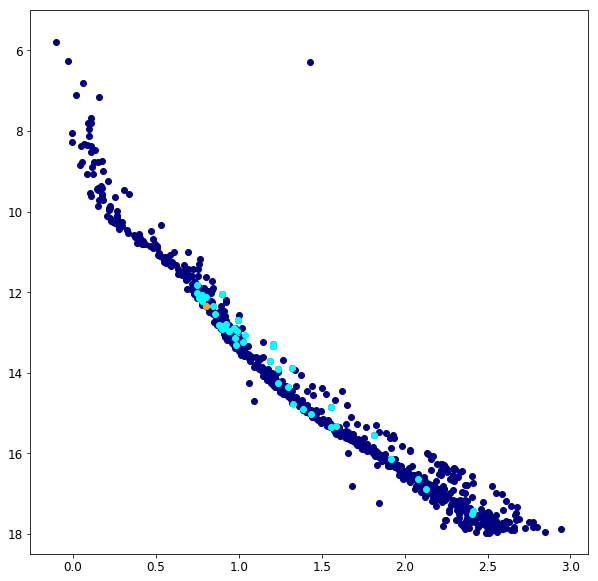

In [2479]:
plt.figure(figsize=(10,10))
plt.scatter(allmems[allmems['proba']>=.5]['bp_rp'],allmems[allmems['proba']>=.5]['phot_g_mean_mag'],color='navy')
plt.scatter(mems_periods[tgtindx]['bp_rp'],mems_periods[tgtindx]['phot_g_mean_mag'],color='cyan')
plt.scatter(mems_periods[tgtindx][oneindx]['bp_rp'],mems_periods[tgtindx][oneindx]['phot_g_mean_mag'],color='orange')

plt.ylim(18.5,5)

(array([71., 56., 66., 39., 28., 29., 21., 24.,  9.,  3.]),
 array([0.16666652, 0.81980483, 1.47294314, 2.12608144, 2.77921975,
        3.43235805, 4.08549636, 4.73863467, 5.39177297, 6.04491128,
        6.69804959]),
 <a list of 10 Patch objects>)

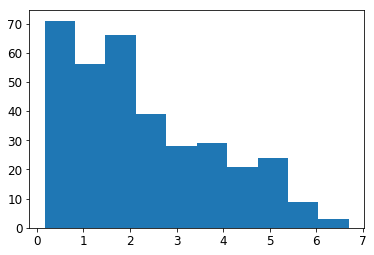

In [25]:
plt.hist(vetperiods[goodindx]['period'])
#plt.hist(mems_periods[tgtindx]['period'])

In [2498]:
extinctbl = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/extinction.dat')
extinctbl[one_num]

objname,ra,dec,cutout_size,E_B_V_SandF,mean_E_B_V_SandF,stdev_E_B_V_SandF,max_E_B_V_SandF,min_E_B_V_SandF,AV_SandF,E_B_V_SFD,mean_E_B_V_SFD,stdev_E_B_V_SFD,max_E_B_V_SFD,min_E_B_V_SFD,AV_SFD,errmsg
,deg,deg,deg,mags,mags,mags,mags,mags,mags,mags,mags,mags,mags,mags,mags,
str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1
--,119.23937,-60.29883,5.0,0.1503,0.1503,0.0041,0.1593,0.1433,0.4661,0.1748,0.1747,0.0048,0.1853,0.1667,0.5419,--


In [2500]:
e1min = extinctbl[one_num]['min_E_B_V_SandF']*3.1
e2min = extinctbl[one_num]['min_E_B_V_SFD']*3.1
e1max = extinctbl[one_num]['max_E_B_V_SandF']*3.1
e2max = extinctbl[one_num]['max_E_B_V_SFD']*3.1

In [2508]:
np.mean((np.min((e1min,e2min)),np.max((e1max,e2max)))), np.std((np.min((e1min,e2min)),np.max((e1max,e2max))))

(0.5093300000000001, 0.06509999999999996)

In [2519]:
#np.mean((.4661,.5419)), np.std((.4661,.5419))
extinctbl[one_num]['min_E_B_V_SandF']*3.1,extinctbl[one_num]['AV_SandF'], extinctbl[one_num]['max_E_B_V_SandF']*3.1

(0.44423000000000007, 0.4661, 0.49383)

In [271]:
(np.sum(vindx), np.sum(cindx), np.sum(xindx), np.sum(zindx), np.sum(uindx))

(311, 209, 575, 11, 0)

In [690]:
(np.sum(vindx), np.sum(cindx), np.sum(xindx), np.sum(zindx), np.sum(uindx))

(253, 231, 611, 11, 0)

In [1033]:
(np.sum(vindx), np.sum(cindx), np.sum(xindx), np.sum(zindx), np.sum(uindx))

(202, 248, 645, 11, 0)

In [1495]:
(np.sum(vindx), np.sum(cindx), np.sum(xindx), np.sum(zindx), np.sum(uindx))

(142, 280, 673, 11, 0)

In [1743]:
(np.sum(vindx), np.sum(cindx), np.sum(xindx), np.sum(zindx), np.sum(uindx))

(114, 295, 686, 11, 0)

In [2398]:
(np.sum(vindx), np.sum(cindx), np.sum(xindx), np.sum(zindx), np.sum(uindx))

(0, 346, 749, 11, 0)

In [42]:
zeroindx = vetperiods[goodindx]['period_unc'] == 0

In [126]:
from astropy.coordinates import SkyCoord
import pandas as pd
ngc2516mems = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NGC_2516_allCGmems.dat')
ngc2516mems = ngc2516mems[(ngc2516mems['proba'] > 0.5) & (~np.isnan(ngc2516mems['bp_rp']))]
gaia_ids = ngc2516mems['source_id']
gmags = ngc2516mems['phot_g_mean_mag']
ra = ngc2516mems['ra']*u.deg
dec = ngc2516mems['dec']*u.deg

SC = SkyCoord(ra,dec)

#close = np.zeros(len(SC),dtype=bool)
count = np.zeros(len(SC))
#inds = np.zeros(len(SC),dtype=int)
closeids = []
closemags = []
closeseps = []
n_stars = np.copy(count)
n_sim_mag = np.copy(count)

for i in range(len(SC)):
    print(i)
#for i in range(496,len(SC)):
#for i in range(93,94):
#####
    df = pd.read_csv('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/close_stars/'+np.str(gaia_ids[i])+'.csv')
    closeids += [df['closeids'].values.tolist()]
    closemags += [df['closemags'].values.tolist()]
    closeseps += [df['closeseps'].values.tolist()]
    
    if -1 not in closeids[i]:
        n_stars[i] = len(closeids[i])
        for j in range(len(closemags[i])):
            if (np.abs(gmags[i]-closemags[i][j]) < 1) & (closeseps[i][j] < 1):
                n_sim_mag[i] += 1
    else:
        n_stars[i] = 0
        n_sim_mag[i] = -1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

(array([127., 223., 188., 143.,   0.,  71.,  26.,   9.,   6.,   1.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

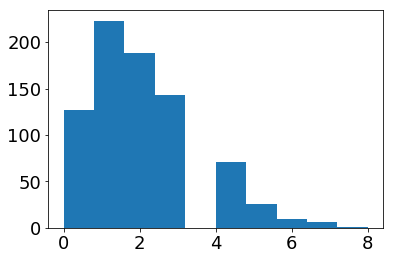

In [127]:
plt.hist(n_stars)

(array([127.,   0., 571.,   0.,   0.,  88.,   0.,   7.,   0.,   1.]),
 array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ,  1.4,  1.8,  2.2,  2.6,  3. ]),
 <a list of 10 Patch objects>)

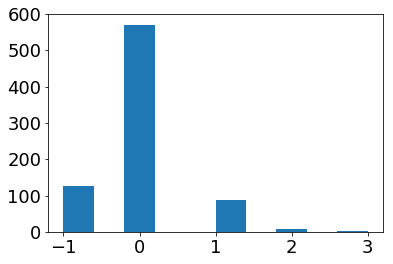

In [128]:
plt.hist(n_sim_mag)

In [221]:
data[vindx]

source_id,period,period_unc,e_period_hwhm,e_period_mad,e_period_std,CDIPS
int64,float64,float64,float64,float64,float64,int64
5289930181318610432,4.0834148675203314,0.05311584717240069,0.5104268584400415,0.06611682078975804,0.05311584717240069,1
5290000309547500800,2.458284338004887,0.020832918118685484,0.3437431489583105,0.04580524956929768,0.020832918118685484,1
5290029103008123520,2.2130699771855555,0.008333238214254381,0.22916405089199543,0.0,0.008333238214254381,1
5289992990923208704,0.4547706396452017,0.015590538562584631,0.1041686674579978,0.022903521163149643,0.015590538562584631,1
5290667678747043584,4.225079357810318,0.017274411907461262,0.5416768407449126,0.013223348493307667,0.017274411907461262,1
5290648093696480640,4.5103296963498,0.11158266760605139,0.6041550170630217,0.07933707093471763,0.11158266760605139,1
5290664929967787264,2.9354707525577393,0.05387641159076604,0.37500690948218107,0.0264466875287171,0.05387641159076604,1
5290655549759621888,2.916721450164914,1.3125246525742114,1.3125246525742114,-1.0,-1.0,1
5290704306227620992,0.9041827805340287,0.022703003265192673,0.10416852310299873,0.013223335784256919,0.022703003265192673,1


In [283]:
classifications[cindx]

source_id,classification
int64,str1
5289930181318610432,V
5290000309547500800,V
5290029103008123520,V
5289992990923208704,V
5290667678747043584,V
5290648093696480640,V
5290664929967787264,V
5290655549759621888,V
5290704306227620992,V


In [129]:
#classifications.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NGC_2516_lc_classifications_vetted.dat',format='ascii')

In [602]:
############## START HERE ##############

In [544]:
#other = 1
#lcindx2 = np.where(classifications['source_id'] == other)[0][0]


classifications = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NGC_2516_lc_classifications_cdips.dat')
cindx = np.where(classifications['classification'] == 'V')[0]
vindx = vetperiods['classification'] == 'V'


x=0
#print(data[vindx][x]['source_id'])#,data[vindx][x]['phot_g_mean_mag'])
print(vetperiods[vindx][x]['source_id'])

#currentindx = [nums][0][x]
#lcindx = np.where(classifications['source_id'] == classifications[vindx]['source_id'][x])[0]
lcindx = np.where(vetperiods['source_id'] == vetperiods[vindx]['source_id'][x])[0]


lcindx = lcindx[0]
classindx = cindx[0]

lcfile = glob.glob('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/cdips_lcgen/Figs/Light_Curves/*'+np.str(vetperiods[vindx][x]['source_id'])+'*')
#lctbl = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/cdips_lcgen/Figs/Light_Curves/'+np.str(lcindx)+'_'+np.str(classifications['source_id'][lcindx])+'_lc.txt')
lctbl = ascii.read(lcfile[0])

lc = lk.LightCurve(time=lctbl['time'],flux=lctbl['flux'],flux_err=lctbl['flux_err'])
lc.scatter(s=.5)

timemasks = {
    's1' : np.where((lc.time >= 1325.293) & (lc.time <= 1353.178))[0],
    's2' : np.where((lc.time >= 1354.101) & (lc.time <= 1381.515))[0],
    's3' : np.where((lc.time >= 1385.897) & (lc.time <= 1406.292))[0],
    's4' : np.where((lc.time >= 1410.900) & (lc.time <= 1436.849))[0],
    's5' : np.where((lc.time >= 1437.826) & (lc.time <= 1464.400))[0],
    's6' : np.where((lc.time >= 1468.270) & (lc.time <= 1490.044))[0],
    's7' : np.where((lc.time >= 1491.626) & (lc.time <= 1516.085))[0],
    's8' : np.where((lc.time >= 1517.342) & (lc.time <= 1542.000))[0],
    's9' : np.where((lc.time >= 1543.216) & (lc.time <= 1568.475))[0],
    's10' : np.where((lc.time >= 1569.432) & (lc.time <= 1595.680))[0],
    's11' : np.where((lc.time >= 1596.772) & (lc.time <= 1623.891))[0],
    's12' : np.where((lc.time >= 1624.950) & (lc.time <= 1652.891))[0],
    's13' : np.where((lc.time >= 1653.915) & (lc.time <= 1682.357))[0]}






IndexError: index 0 out of range for table with length 0

In [539]:
vetperiods[lcindx]

source_id,period,period_unc,e_period_hwhm,e_period_mad,e_period_std,CDIPS,classification
int64,float64,float64,float64,float64,float64,int64,str1
5291032613526130048,1.1041870606131852,0.1562528859358281,0.1562528859358281,-1.0,-1.0,1,V


In [540]:
np.sum(vindx)

1

5290728834785867264 phot_g_mean_mag
---------------
      12.838233


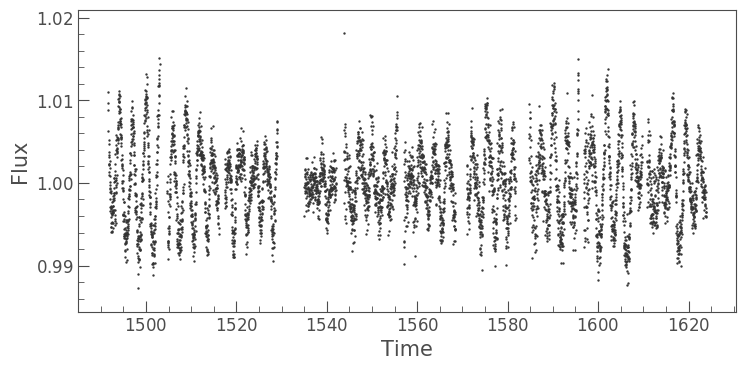

In [602]:
#5290728834785867264
other = 5290728834785867264
#5290653075858442752
y=7
#other = vetperiods[goodindx][zeroindx][y]['source_id']

print(other, mems[mems['source_id']==other]['phot_g_mean_mag'])#,vetperiods[goodindx][zeroindx][y]['period'],vetperiods[goodindx][zeroindx][y]['period_unc'])

#print(other, mems[mems['source_id']==other]['phot_g_mean_mag'],vetperiods[goodindx][zeroindx][y]['period'],vetperiods[goodindx][zeroindx][y]['period_unc'])

lcindx2 = np.where(classifications['source_id'] == other)[0][0]
lcindxfinal = np.where(vetperiods['source_id'] == other)[0][0]

#lctbl2 = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/Figs/Light_Curves/'+np.str(lcindx2)+'_'+np.str(classifications['source_id'][lcindx2])+'_lc.txt')
lctbl2 = ascii.read('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/cdips_lcgen/Figs/Light_Curves/'+np.str(lcindx2)+'_'+np.str(classifications['source_id'][lcindx2])+'_lc.txt')

lc2 = lk.LightCurve(time=lctbl2['time'],flux=lctbl2['flux'],flux_err=lctbl2['flux_err'])
lc = lc2
timemasks = {
    's1' : np.where((lc.time >= 1325.293) & (lc.time <= 1353.178))[0],
    's2' : np.where((lc.time >= 1354.101) & (lc.time <= 1381.515))[0],
    's3' : np.where((lc.time >= 1385.897) & (lc.time <= 1406.292))[0],
    's4' : np.where((lc.time >= 1410.900) & (lc.time <= 1436.849))[0],
    's5' : np.where((lc.time >= 1437.826) & (lc.time <= 1464.400))[0],
    's6' : np.where((lc.time >= 1468.270) & (lc.time <= 1490.044))[0],
    's7' : np.where((lc.time >= 1491.626) & (lc.time <= 1516.085))[0],
    's8' : np.where((lc.time >= 1517.342) & (lc.time <= 1542.000))[0],
    's9' : np.where((lc.time >= 1543.216) & (lc.time <= 1568.475))[0],
    's10' : np.where((lc.time >= 1569.432) & (lc.time <= 1595.680))[0],
    's11' : np.where((lc.time >= 1596.772) & (lc.time <= 1623.891))[0],
    's12' : np.where((lc.time >= 1624.950) & (lc.time <= 1652.891))[0],
    's13' : np.where((lc.time >= 1653.915) & (lc.time <= 1682.357))[0]}


lc2.scatter(s=.5)

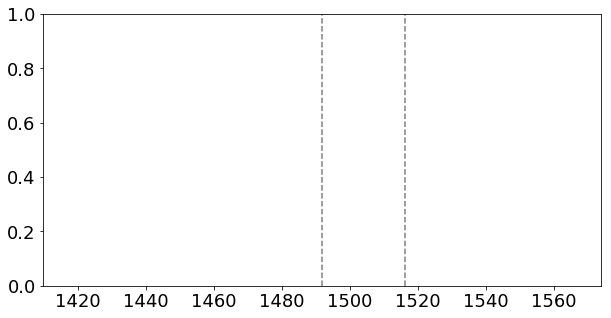

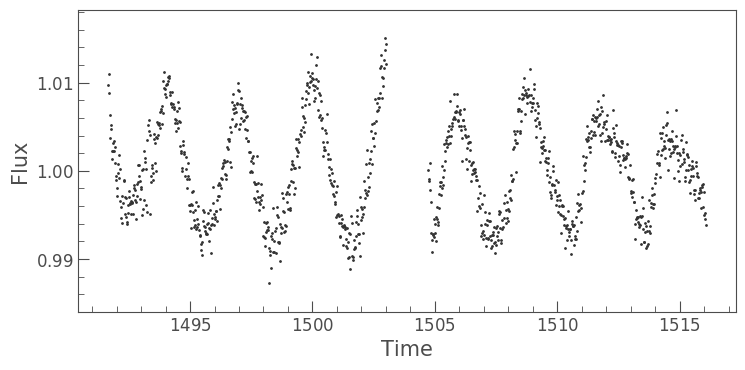

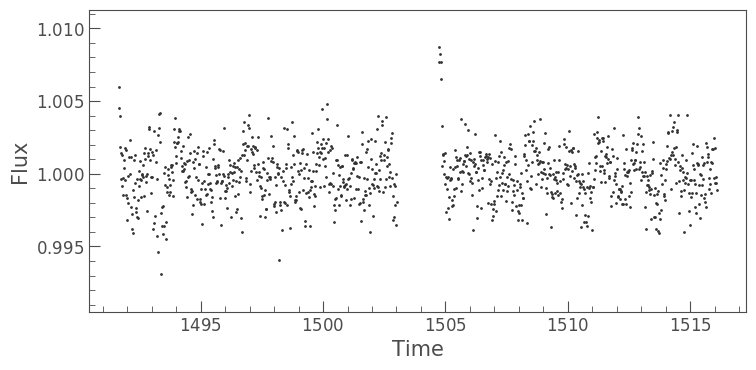

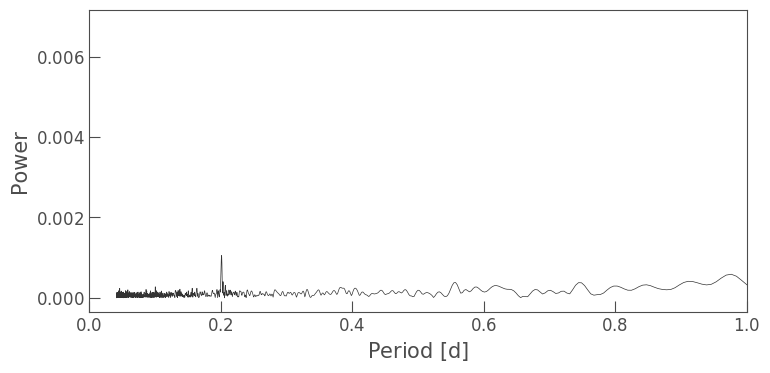

2.961362696784947 0.04370115335317291


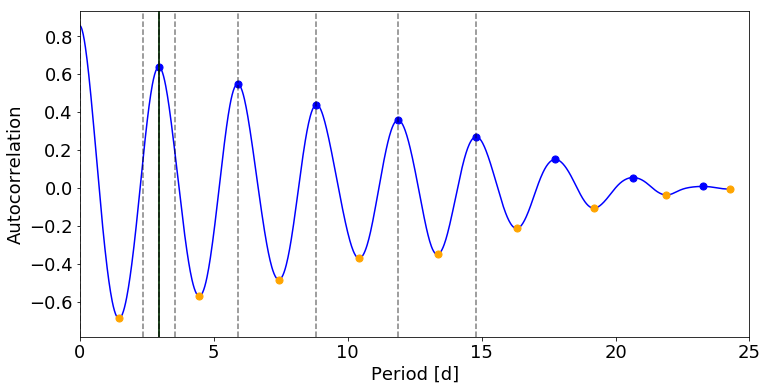

In [604]:
s = 's7'
smth=350
#'s4, s7, s8, s9, s10, s11'
M = timemasks[s]

lcM = lc[M] #.remove_nans().remove_outliers()
#lcM = lcM[0:201]
#lcM = lcM[-200:]
#lcM = lc2[M]

#middletime = (lcM.time[0] + lcM.time[-1])/2
#goodindx = (lcM.time < (middletime - 1.)) | (lcM.time > (middletime + 2.))
#lcM = lk.LightCurve(time = lcM.time[goodindx], flux = lcM.flux[goodindx], flux_err = lcM.flux_err[goodindx])

#finalperiod, period_unc, tau, emp_acorr_smooth, peakinds, valinds, maxheight, periodmults = get_acf_period(lcM,smth)
#finalperiod, period_unc, tau, emp_acorr_smooth, peakinds, valinds, maxheight, periodmults = get_acf_period(lcM.flatten().remove_outliers(),smth)
finalperiod, period_unc, e_period_hwhm, e_period_mad, e_period_std, tau, emp_acorr_smooth, peakinds, valinds, maxheight, periodmults = get_acf_period(lcM,smth)
#finalperiod, period_unc, e_period_hwhm, e_period_mad, e_period_std, tau, emp_acorr_smooth, peakinds, valinds, maxheight, periodmults = get_acf_period(lcM.flatten().remove_outliers(),smth)

#lc = lk.LightCurve(time=lctbl['time'],flux=lctbl['flux'],flux_err=lctbl['flux_err'])
plt.figure(figsize=(10,5))
ax3=plt.subplot()

#lc.scatter(ax=ax3,s=.3,c='black')
#lc2.scatter(ax=ax3,s=.3,c='black')

ax3.axvline(lcM.time[0],color='k',ls='dashed',alpha=.5)
ax3.axvline(lcM.time[-1],color='k',ls='dashed',alpha=.5)
plt.show()

lcM.scatter()
#plt.xlim(1546.5,1547)
#lcM.bin().scatter()
lcM.flatten().remove_outliers().scatter()
lcM.to_periodogram().plot(view='period')
plt.xlim(0,1)
plt.show()

plt.rcParams['font.size']=18
plt.figure(figsize=(12,6))
ax2=plt.subplot()
ax2.plot(tau, emp_acorr_smooth,color='blue',zorder=0)
ax2.scatter(tau[peakinds],emp_acorr_smooth[peakinds],color='blue',s=50)
ax2.scatter(tau[valinds],emp_acorr_smooth[valinds],color='orange',s=50)
ax2.axvline(finalperiod, color="green", alpha=0.9)
#for xx in range(1,6):
for xx in range(1,2):
    ax2.axvline(periodmults[1]*xx,color='k',alpha=.75)#,ls='dashed')
for yy in range(len(periodmults)):
    ax2.axvline(periodmults[yy],color='k',alpha=.5,ls='dashed')
ax2.axvline(periodmults[1]*.8, color="k", alpha=0.5,ls="dashed")
ax2.axvline(periodmults[1]*1.2, color="k", alpha=0.5,ls="dashed")
ax2.set_xlim(0,25)
ax2.set_xlabel('Period [d]')
ax2.set_ylabel('Autocorrelation')

print(finalperiod, period_unc)

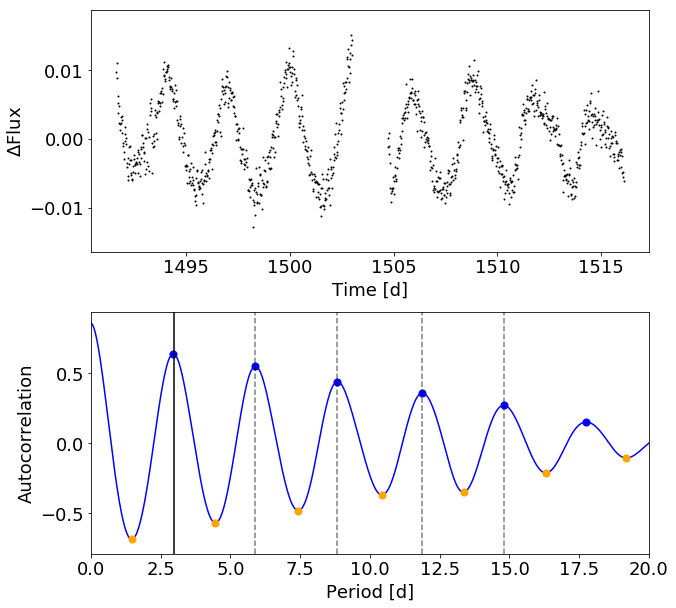

In [606]:
#plt.figure(figsize=(12,12))
#fig,ax = plt.subplots(2,1,figsize=(10,16))
fig,ax = plt.subplots(2,1,figsize=(10,10))

plt.subplots_adjust(hspace=0.25)
ax1 = ax[0]
ax2 = ax[1]
#ax3 = ax[2]

lcM2 = lcM.copy()
lcM2.flux = (lcM2.flux - 1)
lcM2.scatter(ax=ax1,color='black',normalize=False)
ax1.set_xlabel('Time [d]')
ax1.set_ylabel('$\Delta$Flux')
#ax1.set_ylim(.975,1.025)
#ax1.text(1491,.02,'Gaia DR2 ' + np.str(5290728834785867264))
#ax1.text(1510,.02,'$T$ mag. = ' + np.str(12.37))


#ax2=plt.subplot()
ax2.plot(tau, emp_acorr_smooth,color='blue',zorder=0)
ax2.scatter(tau[peakinds],emp_acorr_smooth[peakinds],color='blue',s=50)
ax2.scatter(tau[valinds],emp_acorr_smooth[valinds],color='orange',s=50)
#ax2.axvline(finalperiod, color="green", alpha=0.9)
ax2.axvline(finalperiod, color="black", alpha=1)

#for xx in range(1,6):
#for xx in range(1,2):
#    ax2.axvline(periodmults[1]*xx,color='k',alpha=.75)#,ls='dashed')
for yy in range(2,len(periodmults)):
    ax2.axvline(periodmults[yy],color='k',alpha=.5,ls='dashed')
#ax2.axvline(periodmults[1]*.8, color="k", alpha=0.75,ls="dotted")
#ax2.axvline(periodmults[1]*1.2, color="k", alpha=0.75,ls="dotted")
ax2.set_xlim(0,20)
ax2.set_xlabel('Period [d]')
ax2.set_ylabel('Autocorrelation')

#lcM.to_periodogram().plot(view='period',ax=ax3,color='black',linewidth=1)
#ax3.axvline(vetperiods[lcindxfinal]['period'], color="k", alpha=0.5,ls="dashed")
#ax3.set_xlim(0,20)
#ax2.text(11,.8,'Period = '+np.str(np.round(vetperiods[lcindxfinal]['period'],3))+' $\pm$ '+np.str(np.round(vetperiods[lcindxfinal]['period_unc'],3))+' d',backgroundcolor='white')
#11, .0058
fig.savefig('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperfigs/lc_acf_notext.pdf',bbox_inches='tight')


In [95]:
lcM.to_table().write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperdata/fig2/fig2_lightcurve.txt',format='ascii')




In [98]:
acftbl=Table(data=[tau,emp_acorr_smooth],names=['period','acf'])

In [99]:
acftbl.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/paperdata/fig2/fig2_acf.txt',format='ascii')

In [60]:
vetperiods[lcindxfinal]

source_id,period,period_unc,classification
int64,float64,float64,str1
5290728834785867264,2.9321962631054177,0.00833348511641816,C


In [110]:
#CORRECTING UNCERTAINTIES OF ZERO
vetperiods[lcindxfinal]['period','period_unc'] = finalperiod, period_unc

#classifications[lcindx2]['classification'] = 'C'


vetperiods[lcindxfinal]

source_id,period,period_unc,classification
int64,float64,float64,str1
5290937505770739456,0.6437514552577454,0.013223130017027527,C


In [536]:
vetperiods[lcindx]['period','period_unc'] = finalperiod, period_unc
vetperiods[lcindx]['classification'] = 'C'
classifications[classindx]['classification'] = 'C'


vetperiods[lcindx]



source_id,period,period_unc,e_period_hwhm,e_period_mad,e_period_std,CDIPS,classification
int64,float64,float64,float64,float64,float64,int64,str1
5290940941744376064,0.45060325843681176,0.010206388926340206,0.06250111246481538,0.0,0.010206388926340206,1,C


In [2363]:
data[lcindx2]['period','period_unc'] = finalperiod, period_unc

classifications[lcindx2]['classification'] = 'C'


data[lcindx2]

source_id,period,period_unc
int64,float64,float64
5290954994877585920,1.3101167550124109,0.0065880669300582145


In [2378]:
# ORANGE STAR CLASSIFIC.
classifications[lcindx2]['classification'] = 'X'
data[lcindx2]

source_id,period,period_unc
int64,float64,float64
5291031101697576064,4.2916615198437285,0.9731800624000382


In [542]:
classifications[classindx]['classification'] = 'X'
vetperiods[lcindx]['classification'] = 'X'
vetperiods[lcindx]

source_id,period,period_unc,e_period_hwhm,e_period_mad,e_period_std,CDIPS,classification
int64,float64,float64,float64,float64,float64,int64,str1
5291032613526130048,1.1041870606131852,0.1562528859358281,0.1562528859358281,-1.0,-1.0,1,X


In [568]:
vetperiods.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NGC_2516_ptbl_cdips_vetted.dat',format='ascii',overwrite=True)
classifications.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NGC_2516_lc_classifications_cdips_vetted.dat',format='ascii',overwrite=True)


In [567]:
classifications[4]['classification']='X'

In [566]:
vetperiods[0]['classification']='X'

In [417]:
files = glob.glob('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NewF_ACF_DVRs/*.pdf')
index = np.zeros(len(files),dtype=int)
for i in range(len(files)):
    index[i] = np.int(files[i].split('/')[-1].split('_')[0])

In [418]:
Tbl = Table(data=[files,index],names=['files','index'])
Tbl.sort(keys='index')

In [419]:
Tbl[nums]

files,index
str90,int64
/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NewF_ACF_DVRs/1_5289864726018908544_dvr.pdf,1
/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NewF_ACF_DVRs/3_5289894515912156544_dvr.pdf,3
/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NewF_ACF_DVRs/4_5289881768449288576_dvr.pdf,4
/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NewF_ACF_DVRs/35_5289864515563819008_dvr.pdf,35
/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NewF_ACF_DVRs/44_5289990894979321344_dvr.pdf,44
/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NewF_ACF_DVRs/46_5289978010077507328_dvr.pdf,46
/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NewF_ACF_DVRs/47_5289996633055417728_dvr.pdf,47
/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NewF_ACF_DVRs/49_5290000069029332736_dvr.pdf,49
/Users/bhealy/Documents/PhD_Thesis/NGC_2516/NewF_ACF_DVRs/50_5289982545563048832_dvr.pdf,50


In [420]:
merger = PdfFileMerger()
for i in range(len(Tbl[nums])):
    merger.append(PdfFileReader(Tbl['files'][nums[i]],'rb'))
merger.write('/Users/bhealy/Documents/PhD_Thesis/NGC_2516/Validate_DVRs.pdf')

    